#  Evolutionary Multiple-objective Optimization (part for 4.0)

- This script is for those who want to improve their final grade from 3.0 to 4.0. 
- Your task is to implement any one evolutionary algorithm for multiple-objective optimization introduced during the lecture (NSGA-II/NSGA-III/MOEA/D; except for NSGA).
- Note that it has to be your implementation (using external libraries is forbidden; EXCEPTION: you can use the JECDM framework: https://jecdm.cs.put.poznan.pl -- but it is a relatively complex software, and much effort must be spent to understand how to use it).
- The problem to be solved is the portfolio optimization tackled during lab 1.
- You can use the same data and price predictions as you made for lab 1 (Bundle1.zip) or update them accordingly to the next stage if you participate in the portfolio game (it is up to you).
- Apart from the two-objective scenario, tackle also a three-objective one. As for the third objective, think about some reasonable risk-measure. E.g., you can maximize the number of non-zero weights, which should refer to minimizing risk by diversifying investments.
- Perform experimental evaluation of your implementation. You can use, e.g., the IDG or the HV metric to quantify the quality of populations constructed by the method.
- The experimental evaluation should be "reasonably extensive." E.g., run your method multiple times and average the results, show average convergence plots, do the sensitivity analysis (just four combinations of population size/generations will be enough), and depict some final populations. Also, compare the populations (only for 2D scenarios) with those generated by the ECM or WSM algorithm. Note that ECM and WSM already generate Pareto optimal solutions, so these can be considered good benchmarks for comparison.
- You can report your results here, i.e., in the jupyter notebook. You do not need to prepare any pdf report, etc. 

# Lab 1

Import the necessary libraries (numpy, pandas, matplotlib, cvxopt).

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.linear_model import Lasso
from scipy.signal import savgol_filter

# For reproducible randomness
np.random.seed(42)

Load the data from *Part1.txt files. Each file’s first line is the asset name, second line is N, and then N lines with “time price”.

In [ ]:
def load_asset_data(data_folder="Bundle3"):
    asset_names = []
    asset_times = []
    asset_prices = []
    
    txt_files = [f for f in os.listdir(data_folder) if f.endswith("Part3.txt")]
    
    for fname in txt_files:
        path = os.path.join(data_folder, fname)
        with open(path, "r") as f:
            # 1) asset name
            asset_name = f.readline().strip()
    
            # 2) number of data points
            N_line = f.readline().strip()
            N = int(N_line)
    
            # 3) read time, price lines
            times = []
            prices = []
            for _ in range(N):
                line = f.readline().strip()
                t_str, p_str = line.split()
                times.append(float(t_str))
                prices.append(float(p_str))
    
            asset_names.append(asset_name)
            asset_times.append(times)
            asset_prices.append(prices)
    
    print(f"Found {len(asset_names)} assets.")
    print("First few asset names:", asset_names[:5])
    return asset_names, asset_times, asset_prices

asset_names, asset_times, asset_prices = load_asset_data()

In [ ]:
from stock_predictor import StockPredictor

# Create an instance with your data folder - works with any bundle number
# Examples: "Bundle2", "Bundle3", etc.
sp = StockPredictor(data_folder="Bundle3")  # Change to your actual data folder

# Generate and plot market-aware predictions that account for market cycles
market_predictions = sp.plot_market_aware_predictions(
    training_start=0,
    training_end=None,  # Will default to the last available time point
    forecast_time=None, # Will default to training_end + 100
    show_raw=True,      # Show both raw model and market-adjusted forecasts
    verbose=False       # Set to True for detailed output
)

# The market_predictions variable now contains the curve fit results for each asset
# Example of accessing a specific asset's prediction:
# asset_prediction = market_predictions["AssetName"]
# print(asset_prediction["model_name"])         # The selected model
# print(asset_prediction["predicted_return"])   # The forecasted return percentage
# print(asset_prediction["market_info"])        # Market cycle information

### Markowitz Model using **mean** results

In [ ]:
# Extract expected returns from mean results
expected_returns = np.array([market_predictions[asset]["predicted_return"] / 100.0 for asset in asset_names])
n_assets = len(asset_names)

# Compute covariance matrix using historical data
historical_returns = []
for i, asset in enumerate(asset_names):
    # Get prices during training period
    prices = np.array(asset_prices[i])
    times = np.array(asset_times[i])
    mask = (times >= 0) & (times <= 100)
    asset_prices_train = prices[mask]
    
    # Calculate returns
    asset_returns = np.diff(asset_prices_train) / asset_prices_train[:-1]
    historical_returns.append(asset_returns)

# Ensure all historical returns have the same length
min_length = min(len(returns) for returns in historical_returns)
historical_returns = [returns[:min_length] for returns in historical_returns]
historical_returns = np.array(historical_returns)

# Compute covariance matrix
cov_matrix = np.cov(historical_returns)

# Ensure covariance matrix is positive semi-definite
eigenvalues = np.linalg.eigvalsh(cov_matrix)
if np.any(eigenvalues < 0):
    cov_matrix += np.eye(n_assets) * 1e-8

print("Expected Returns (sample):")
for i in range(min(5, n_assets)):
    print(f"{asset_names[i]}: {expected_returns[i]:.4f}")

print("\nCovariance Matrix (sample):")
print(cov_matrix[:3, :3])

# Find minimum risk portfolio
def solve_min_risk():
    """Find the portfolio with minimum risk"""
    P = matrix(cov_matrix)
    q = matrix(np.zeros(n_assets))
    
    # Constraint: w ≥ 0
    G = matrix(-np.eye(n_assets))
    h = matrix(np.zeros(n_assets))
    
    # Constraint: sum(w) = 1
    A = matrix(np.ones((1, n_assets)))
    b = matrix(np.ones(1))
    
    sol = solvers.qp(P, q, G, h, A, b)
    weights = np.array(sol['x']).flatten()
    port_return = np.dot(weights, expected_returns)
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    return weights, port_risk, port_return

# Find maximum return portfolio
def solve_max_return():
    """Find the portfolio with maximum return"""
    c = matrix(-expected_returns)  # Negative because we minimize -r^T w
    
    # Constraint: w ≥ 0
    G = matrix(-np.eye(n_assets))
    h = matrix(np.zeros(n_assets))
    
    # Constraint: sum(w) = 1
    A = matrix(np.ones((1, n_assets)))
    b = matrix(np.ones(1))
    
    sol = solvers.lp(c, G, h, A, b)
    weights = np.array(sol['x']).flatten()
    port_return = np.dot(weights, expected_returns)
    port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    return weights, port_return, port_risk

# Find the extreme portfolios
min_risk_weights, min_risk_value, min_risk_return = solve_min_risk()
max_return_weights, max_return_value, max_return_risk = solve_max_return()

print("\nMinimum Risk Portfolio:")
print(f"Risk: {min_risk_value:.6f}")
print(f"Return: {min_risk_return:.6f}")

print("\nMaximum Return Portfolio:")
print(f"Return: {max_return_value:.6f}")
print(f"Risk: {max_return_risk:.6f}")

### Implementation of the two multi-objective methods:
- **Weighted Sum Method (WSM)**  
- **Epsilon-Constraint Method (ECM)**  

In [ ]:
# Suppress solver output
solvers.options['show_progress'] = False

# Weighted Sum Method (WSM)
def weighted_sum_method(n_weights=10, normalize=True):
    # Set up normalization ranges if needed
    if normalize:
        return_range = max_return_value - min_risk_return
        risk_range = max_return_risk - min_risk_value
    
    # Generate weight vectors
    weight_vectors = []
    for i in range(n_weights):
        w_return = i / (n_weights - 1)  # Weight for return
        w_risk = 1 - w_return           # Weight for risk
        weight_vectors.append((w_return, w_risk))
    
    # Solve for each weight vector
    solutions = []
    for w_return, w_risk in weight_vectors:
        # Setup quadratic programming parameters
        P = matrix(cov_matrix)
        q = matrix(np.zeros(n_assets))
        
        if normalize:
            # For normalized objective function
            q_mod = matrix(-w_return * expected_returns / return_range)
            P_mod = matrix(w_risk * cov_matrix / risk_range)
        else:
            # For non-normalized objective function
            q_mod = matrix(-w_return * expected_returns)
            P_mod = matrix(w_risk * cov_matrix)
        
        # Constraint: w ≥ 0
        G = matrix(-np.eye(n_assets))
        h = matrix(np.zeros(n_assets))
        
        # Constraint: sum(w) = 1
        A = matrix(np.ones((1, n_assets)))
        b = matrix(np.ones(1))
        
        # Solve QP
        sol = solvers.qp(P_mod, q_mod, G, h, A, b)
        
        if sol['status'] != 'optimal':
            print(f"Warning: Optimization did not reach an optimal solution for weights {w_return}, {w_risk}. Status: {sol['status']}")
            continue
        
        weights = np.array(sol['x']).flatten()
        port_return = np.dot(weights, expected_returns)
        port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        solutions.append((weights, port_return, port_risk))
    
    # Filter duplicate solutions
    unique_solutions = []
    for sol in solutions:
        is_unique = True
        for existing_sol in unique_solutions:
            if (np.abs(sol[1] - existing_sol[1]) < 1e-6 and 
                np.abs(sol[2] - existing_sol[2]) < 1e-6):
                is_unique = False
                break
        if is_unique:
            unique_solutions.append(sol)
    
    return unique_solutions

# Epsilon-Constraint Method (ECM)
def epsilon_constraint_method(n_thresholds=10):
    """
    Implements the Epsilon-Constraint Method for portfolio optimization.
    
    Args:
        n_thresholds: Number of threshold values to use
    
    Returns:
        List of Pareto optimal solutions (weights, return, risk)
    """
    # Generate threshold values
    thresholds = []
    for i in range(n_thresholds):
        t = min_risk_return + (i / (n_thresholds - 1)) * (max_return_value - min_risk_return)
        thresholds.append(t)
    
    # Solve for each threshold
    solutions = []
    for threshold in thresholds:
        # Setup quadratic programming parameters
        P = matrix(cov_matrix)
        q = matrix(np.zeros(n_assets))
        
        # Constraint: w ≥ 0
        G = matrix(-np.eye(n_assets))
        h = matrix(np.zeros(n_assets))
        
        # Constraints: sum(w) = 1 and r^T w >= threshold
        A = matrix(np.vstack((
            np.ones(n_assets),     # sum(w) = 1
            expected_returns       # r^T w >= threshold
        )))
        b = matrix(np.array([1.0, threshold]))
        
        # Solve QP
        sol = solvers.qp(P, q, G, h, A, b)
        
        if sol['status'] != 'optimal':
            print(f"Warning: Optimization did not reach an optimal solution for threshold {threshold}. Status: {sol['status']}")
            continue
        
        weights = np.array(sol['x']).flatten()
        port_return = np.dot(weights, expected_returns)
        port_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        
        solutions.append((weights, port_return, port_risk))
    
    # Filter duplicate solutions
    unique_solutions = []
    for sol in solutions:
        is_unique = True
        for existing_sol in unique_solutions:
            if (np.abs(sol[1] - existing_sol[1]) < 1e-6 and 
                np.abs(sol[2] - existing_sol[2]) < 1e-6):
                is_unique = False
                break
        if is_unique:
            unique_solutions.append(sol)
    
    return unique_solutions

# Function to plot Pareto front
def plot_pareto_front(solutions, title):
    risks = [sol[2] for sol in solutions]
    returns = [sol[1] for sol in solutions]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(risks, returns, c='red', marker='o')
    plt.xlabel('Risk')
    plt.ylabel('Expected Return')
    plt.title(title)
    plt.grid(True)
    plt.show()

# Test the methods with a small number of points
wsm_solutions = weighted_sum_method(100)
ecm_solutions = epsilon_constraint_method(10)

print(f"WSM found {len(wsm_solutions)} unique solutions")
print(f"ECM found {len(ecm_solutions)} unique solutions")

plot_pareto_front(wsm_solutions, "WSM Pareto Front")
plot_pareto_front(ecm_solutions, "ECM Pareto Front")

# Lab 2

In [14]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time
from mpl_toolkits.mplot3d import Axes3D
from cvxopt import matrix, solvers

# Suppress solver output
solvers.options['show_progress'] = False

# Seed for reproducibility
np.random.seed(42)
random.seed(42)

class NSGA2:
    def __init__(self, n_assets, expected_returns, cov_matrix, 
                 pop_size=100, max_gen=100, crossover_prob=0.9, mutation_prob=0.1,
                 tournament_size=2, mutation_strength=0.1, n_objectives=2,
                 adaptive_mutation=False, mutation_min=0.01, mutation_max=0.25,
                 hybrid_optimization=False, hybrid_frequency=20):
        self.n_assets = n_assets
        self.expected_returns = expected_returns
        self.cov_matrix = cov_matrix
        self.pop_size = pop_size
        self.max_gen = max_gen
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob
        self.tournament_size = tournament_size
        self.mutation_strength = mutation_strength
        self.n_objectives = n_objectives
        
        # Adaptive mutation parameters
        self.adaptive_mutation = adaptive_mutation
        self.mutation_min = mutation_min
        self.mutation_max = mutation_max
        self.current_mutation_rate = mutation_prob
        self.convergence_window = 5  # Number of generations to check for convergence
        self.convergence_threshold = 0.001  # Threshold for detecting convergence
        
        # Hybrid optimization parameters
        self.hybrid_optimization = hybrid_optimization
        self.hybrid_frequency = hybrid_frequency  # How often to apply QP refinement
        
        # For tracking metrics
        self.hypervolume_history = []
        self.igd_history = []
        self.reference_point = None
        self.diversity_history = []  # Track population diversity
    
    def initialize_population(self):
        population = []
        
        for _ in range(self.pop_size):
            # Generate random weights
            weights = np.random.random(self.n_assets)
            weights /= np.sum(weights)  # Normalize to sum to 1
            
            # Evaluate objectives
            objectives = self.evaluate_objectives(weights)
            
            # Create individual
            individual = {
                'weights': weights,
                'objectives': objectives,
                'rank': None,
                'crowding_distance': None
            }
            
            population.append(individual)
        
        return population
    
    def evaluate_objectives(self, weights):
        # Expected return (we negate it because we're minimizing)
        expected_return = -np.dot(weights, self.expected_returns)
        
        # Risk (standard deviation)
        risk = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
        
        if self.n_objectives == 2:
            return np.array([expected_return, risk])
        
        # Diversification measure (negative because we want to maximize)
        # Count number of assets with significant weight (>1%)
        diversification = -np.sum(weights > 0.01)
        
        return np.array([expected_return, risk, diversification])
    
    def dominates(self, ind1, ind2):
        # ind1 dominates ind2 if:
        # 1. ind1 is no worse than ind2 in all objectives
        # 2. ind1 is strictly better than ind2 in at least one objective
        
        obj1 = ind1['objectives']
        obj2 = ind2['objectives']
        
        no_worse = np.all(obj1 <= obj2)
        strictly_better = np.any(obj1 < obj2)
        
        return no_worse and strictly_better
    
    def fast_non_dominated_sort(self, population):
        # Initialize with first front
        fronts = []
        first_front = []
        
        # For each individual
        for i, p in enumerate(population):
            p['domination_count'] = 0  # Number of solutions that dominate p
            p['dominated_solutions'] = []  # Set of solutions that p dominates
            
            for j, q in enumerate(population):
                if i == j:
                    continue
                    
                if self.dominates(p, q):
                    p['dominated_solutions'].append(j)
                elif self.dominates(q, p):
                    p['domination_count'] += 1
            
            if p['domination_count'] == 0:
                p['rank'] = 0  # Rank of the first front
                first_front.append(i)
        
        # Add first front if not empty
        if first_front:
            fronts.append(first_front)
        else:
            # If no non-dominated solutions found, add the best one
            # This is a fallback to prevent empty fronts
            min_dom_count = float('inf')
            min_dom_idx = 0
            for i, p in enumerate(population):
                if p['domination_count'] < min_dom_count:
                    min_dom_count = p['domination_count']
                    min_dom_idx = i
            
            if min_dom_count < float('inf'):
                population[min_dom_idx]['rank'] = 0
                fronts.append([min_dom_idx])
        
        # Find subsequent fronts
        i = 0
        while i < len(fronts):  # Safe check against fronts length
            next_front = []
            
            for p_idx in fronts[i]:
                p = population[p_idx]
                
                for q_idx in p['dominated_solutions']:
                    q = population[q_idx]
                    q['domination_count'] -= 1
                    
                    if q['domination_count'] == 0:
                        q['rank'] = i + 1
                        next_front.append(q_idx)
            
            i += 1
            if next_front:
                fronts.append(next_front)
        
        return fronts
    
    def calculate_crowding_distance(self, population, front):
        if len(front) <= 2:
            for idx in front:
                population[idx]['crowding_distance'] = float('inf')
            return
        
        n_objectives = len(population[0]['objectives'])
        
        for idx in front:
            population[idx]['crowding_distance'] = 0
        
        for obj_idx in range(n_objectives):
            # Sort the front by the objective value
            front_sorted = sorted(front, key=lambda x: population[x]['objectives'][obj_idx])
            
            # Set boundary points to infinity
            population[front_sorted[0]]['crowding_distance'] = float('inf')
            population[front_sorted[-1]]['crowding_distance'] = float('inf')
            
            # Calculate crowding distance for other points
            obj_range = (population[front_sorted[-1]]['objectives'][obj_idx] - 
                         population[front_sorted[0]]['objectives'][obj_idx])
            
            if obj_range == 0:
                continue  # Skip if all values are the same
                
            for i in range(1, len(front_sorted) - 1):
                distance = (population[front_sorted[i+1]]['objectives'][obj_idx] - 
                           population[front_sorted[i-1]]['objectives'][obj_idx]) / obj_range
                
                population[front_sorted[i]]['crowding_distance'] += distance
    
    def tournament_selection(self, population, k=2):
        # Ensure k is not larger than population size
        k = min(k, len(population))
        
        # Select k random individuals
        candidates = random.sample(population, k)
        
        # Find the best by comparing rank first, then crowding distance
        best = candidates[0]
        
        for candidate in candidates[1:]:
            # Handle case where rank might be None
            if candidate['rank'] is None and best['rank'] is None:
                # If both ranks are None, use crowding distance
                if candidate['crowding_distance'] > best['crowding_distance']:
                    best = candidate
            elif candidate['rank'] is None:
                continue  # Keep best if candidate rank is None
            elif best['rank'] is None:
                best = candidate  # Replace if best rank is None
            # Normal comparison
            elif candidate['rank'] < best['rank']:
                best = candidate
            elif candidate['rank'] == best['rank'] and candidate['crowding_distance'] > best['crowding_distance']:
                best = candidate
        
        return best
    
    def simulated_binary_crossover(self, parent1, parent2, eta=1):
        p1 = parent1['weights'].copy()
        p2 = parent2['weights'].copy()
        
        # Apply SBX
        if random.random() <= self.crossover_prob:
            child1 = np.zeros_like(p1)
            child2 = np.zeros_like(p2)
            
            for i in range(len(p1)):
                if random.random() <= 0.5:
                    if abs(p1[i] - p2[i]) > 1e-10:
                        if p1[i] < p2[i]:
                            y1, y2 = p1[i], p2[i]
                        else:
                            y1, y2 = p2[i], p1[i]
                        
                        beta = 1.0 + (2.0 * (y1 - 0.0)) / (y2 - y1)
                        alpha = 2.0 - beta ** (-(eta + 1.0))
                        
                        rand = random.random()
                        if rand <= 1.0 / alpha:
                            beta_q = (rand * alpha) ** (1.0 / (eta + 1.0))
                        else:
                            beta_q = (1.0 / (2.0 - rand * alpha)) ** (1.0 / (eta + 1.0))
                        
                        c1 = 0.5 * ((y1 + y2) - beta_q * (y2 - y1))
                        c2 = 0.5 * ((y1 + y2) + beta_q * (y2 - y1))
                        
                        c1 = max(0.0, min(1.0, c1))
                        c2 = max(0.0, min(1.0, c2))
                        
                        child1[i] = c1
                        child2[i] = c2
                    else:
                        child1[i] = p1[i]
                        child2[i] = p2[i]
                else:
                    child1[i] = p1[i]
                    child2[i] = p2[i]
        else:
            child1 = p1.copy()
            child2 = p2.copy()
        
        # Normalize to sum to 1
        child1 /= np.sum(child1)
        child2 /= np.sum(child2)
        
        return child1, child2
    
    def polynomial_mutation(self, individual, eta=20, mutation_prob=None):
        """Apply polynomial mutation with adaptive mutation rate"""
        if mutation_prob is None:
            mutation_prob = self.current_mutation_rate if self.adaptive_mutation else self.mutation_prob
            
        mutated = individual.copy()
        
        for i in range(len(mutated)):
            if random.random() <= mutation_prob:
                # Get the boundaries
                lb, ub = 0.0, 1.0
                
                # Apply polynomial mutation
                delta1 = (mutated[i] - lb) / (ub - lb)
                delta2 = (ub - mutated[i]) / (ub - lb)
                
                rand = random.random()
                mut_pow = 1.0 / (eta + 1.0)
                
                if rand <= 0.5:
                    xy = 1.0 - delta1
                    val = 2.0 * rand + (1.0 - 2.0 * rand) * (xy ** (eta + 1.0))
                    deltaq = val ** mut_pow - 1.0
                else:
                    xy = 1.0 - delta2
                    val = 2.0 * (1.0 - rand) + 2.0 * (rand - 0.5) * (xy ** (eta + 1.0))
                    deltaq = 1.0 - val ** mut_pow
                
                mutated[i] += deltaq * (ub - lb)
                mutated[i] = max(lb, min(ub, mutated[i]))
        
        # Normalize to sum to 1
        mutated /= np.sum(mutated)
        
        return mutated
    
    def create_offspring(self, population):
        offspring = []
        
        while len(offspring) < self.pop_size:
            # Tournament selection
            parent1 = self.tournament_selection(population, self.tournament_size)
            parent2 = self.tournament_selection(population, self.tournament_size)
            
            # Crossover
            child1_weights, child2_weights = self.simulated_binary_crossover(parent1, parent2)
            
            # Mutation
            child1_weights = self.polynomial_mutation(child1_weights)
            child2_weights = self.polynomial_mutation(child2_weights)
            
            # Evaluate objectives
            child1_objectives = self.evaluate_objectives(child1_weights)
            child2_objectives = self.evaluate_objectives(child2_weights)
            
            # Create child individuals
            child1 = {
                'weights': child1_weights,
                'objectives': child1_objectives,
                'rank': None,
                'crowding_distance': None
            }
            
            child2 = {
                'weights': child2_weights,
                'objectives': child2_objectives,
                'rank': None,
                'crowding_distance': None
            }
            
            offspring.append(child1)
            offspring.append(child2)
        
        # Take only pop_size offspring
        return offspring[:self.pop_size]
    
    def select_next_generation(self, population, offspring):
        # Combine parent and offspring populations
        combined = population + offspring
        
        # Apply non-dominated sorting
        fronts = self.fast_non_dominated_sort(combined)
        
        # Select individuals for the next generation
        next_gen = []
        front_idx = 0
        
        while front_idx < len(fronts) and len(next_gen) + len(fronts[front_idx]) <= self.pop_size:
            # Calculate crowding distance for the current front
            self.calculate_crowding_distance(combined, fronts[front_idx])
            
            # Add all individuals from the current front
            for idx in fronts[front_idx]:
                next_gen.append(combined[idx])
            
            front_idx += 1
        
        # If we need more individuals, add them based on crowding distance
        if len(next_gen) < self.pop_size and front_idx < len(fronts):
            # Calculate crowding distance for the last front
            self.calculate_crowding_distance(combined, fronts[front_idx])
            
            # Sort the last front by crowding distance
            last_front = sorted(fronts[front_idx], 
                                key=lambda x: combined[x]['crowding_distance'],
                                reverse=True)
            
            # Add individuals from the last front until the population is filled
            remaining = self.pop_size - len(next_gen)
            for i in range(min(remaining, len(last_front))):
                next_gen.append(combined[last_front[i]])
        
        return next_gen
    
    def calculate_hypervolume(self, population):
        """Calculate hypervolume indicator for the given population."""
        # Find the first front (non-dominated solutions)
        fronts = self.fast_non_dominated_sort(population)
        
        # Handle case where fronts might be empty
        if not fronts:
            return 0.0
            
        first_front_indices = fronts[0]
        if not first_front_indices:
            return 0.0
            
        first_front = [population[idx] for idx in first_front_indices]
        
        # Extract objectives of the first front
        objectives = np.array([ind['objectives'] for ind in first_front])
        
        # Initialize reference point if not already set
        if self.reference_point is None:
            # For portfolio problem, set reasonable reference points:
            # - For return (obj[0]): Worst return (most negative value) * 1.1
            # - For risk (obj[1]): Highest risk value * 1.1
            # - For diversification (obj[2] if exists): Least diversification * 1.1
            
            # Get worst values from all individuals
            all_objectives = np.array([ind['objectives'] for ind in population])
            # Objective 0 is negative return (minimizing), so take max
            # Objective 1 is risk (minimizing), so take max
            # Objective 2 is negative diversification (minimizing), so take max
            worst_values = np.max(all_objectives, axis=0) * 1.1
            
            # Ensure the reference point is sufficiently worse than all solutions
            self.reference_point = worst_values
            print(f"Set reference point: {self.reference_point}")
        
        # For 2 objectives, use the sweep line algorithm
        if self.n_objectives == 2:
            return self._hypervolume_2d(objectives)
        
        # For 3 objectives, use Monte Carlo approximation
        return self._hypervolume_3d_monte_carlo(objectives, n_samples=10000)
    
    def _hypervolume_2d(self, objectives):
        """
        Calculate 2D hypervolume using a correct sweep line algorithm
        """
        if len(objectives) == 0:
            return 0.0
            
        # For minimization problems, we need to:
        # 1. Sort by first objective (expected return, which is negated for minimization)
        # 2. Keep track of the best second objective value seen so far
        
        # Sort points by first objective (ascending)
        sorted_idx = np.argsort(objectives[:, 0])
        sorted_objectives = objectives[sorted_idx]
        
        # Initialize hypervolume
        hypervolume = 0.0
        
        # Keep track of the best second objective value seen so far
        # (lowest value for second objective since we're minimizing)
        prev_min_y = self.reference_point[1]
        
        # Process the points from best to worst on first objective
        for i in range(len(sorted_objectives)):
            # Current point
            x = sorted_objectives[i, 0]
            y = sorted_objectives[i, 1]
            
            # Only consider points that improve second objective
            if y < prev_min_y:
                # Calculate the area contribution of this point
                # Width is distance from current x to previous x
                if i > 0:
                    width = x - sorted_objectives[i-1, 0]
                else:
                    width = x - 0  # Assume 0 as the lower bound for the first point
                    
                # Height is improvement in the second objective
                height = prev_min_y - y
                
                # Add area to hypervolume
                hypervolume += width * height
                
                # Update best second objective
                prev_min_y = y
        
        # Add the final contribution (from last point to reference point)
        if len(sorted_objectives) > 0:
            last_x = sorted_objectives[-1, 0]
            last_y = prev_min_y
            
            width = self.reference_point[0] - last_x
            height = self.reference_point[1] - last_y
            hypervolume += width * height
        
        return hypervolume
    
    def _hypervolume_3d_monte_carlo(self, objectives, n_samples=10000):
        # Generate random samples
        samples = np.random.uniform(
            low=np.min(objectives, axis=0),
            high=self.reference_point,
            size=(n_samples, self.n_objectives)
        )
        
        # Count samples in the dominated hypervolume
        count = 0
        for sample in samples:
            for point in objectives:
                if np.all(sample >= point) and np.all(sample <= self.reference_point):
                    count += 1
                    break
        
        # Calculate hypervolume as a fraction of the reference volume
        reference_volume = np.prod(self.reference_point - np.min(objectives, axis=0))
        hypervolume = (count / n_samples) * reference_volume
        
        return hypervolume
    
    def calculate_igd(self, population, reference_front=None):
        # If no reference front, IGD doesn't make sense
        if reference_front is None or len(reference_front) == 0:
            return 0.0
            
        # Find the first front (non-dominated solutions)
        fronts = self.fast_non_dominated_sort(population)
        
        # Handle case where fronts might be empty
        if not fronts or len(fronts[0]) == 0:
            return float('inf')  # Worst possible IGD if no solutions
            
        first_front_indices = fronts[0]
        first_front = [population[idx] for idx in first_front_indices]
        
        # Extract objectives of the first front
        objectives = np.array([ind['objectives'] for ind in first_front])
        
        # Calculate the minimum distance from each point in the reference front to the current front
        distances = []
        for ref_point in reference_front:
            min_dist = float('inf')
            for point in objectives:
                dist = np.linalg.norm(ref_point - point)
                min_dist = min(min_dist, dist)
            distances.append(min_dist)
        
        # IGD is the average of these minimum distances
        igd = np.mean(distances)
        
        return igd
    
    def calculate_population_diversity(self, population):
        """Calculate diversity of the population based on genotype (weights)"""
        if not population:
            return 0.0
            
        # Extract weights
        weights = np.array([ind['weights'] for ind in population])
        
        # Calculate average euclidean distance between all pairs of individuals
        n = len(weights)
        if n <= 1:
            return 0.0
            
        total_distance = 0.0
        for i in range(n):
            for j in range(i+1, n):
                total_distance += np.linalg.norm(weights[i] - weights[j])
        
        # Normalize by number of pairs
        diversity = total_distance / (n * (n-1) / 2)
        return diversity
    
    def update_mutation_rate(self, generation):
        """Update mutation rate based on population diversity and convergence"""
        if not self.adaptive_mutation or generation < self.convergence_window:
            return self.mutation_prob
        
        # Check for convergence based on hypervolume history
        recent_hv = self.hypervolume_history[-self.convergence_window:]
        hv_change = np.abs(recent_hv[-1] - recent_hv[0])
        normalized_change = hv_change / (recent_hv[0] + 1e-10)  # Avoid division by zero
        
        # Check diversity trend
        if len(self.diversity_history) >= self.convergence_window:
            recent_diversity = self.diversity_history[-self.convergence_window:]
            diversity_trend = recent_diversity[-1] / (recent_diversity[0] + 1e-10) - 1.0
        else:
            diversity_trend = 0.0
        
        # Adjust mutation rate
        if normalized_change < self.convergence_threshold:
            # Increase mutation rate if converging to promote exploration
            self.current_mutation_rate = min(self.mutation_max, 
                                        self.current_mutation_rate * 1.5)
        elif diversity_trend < -0.1:  # Diversity is dropping
            # Increase mutation rate to maintain diversity
            self.current_mutation_rate = min(self.mutation_max, 
                                        self.current_mutation_rate * 1.2)
        else:
            # Gradually decrease mutation rate if progressing well
            self.current_mutation_rate = max(self.mutation_min, 
                                        self.current_mutation_rate * 0.95)
        
        return self.current_mutation_rate
    
    def optimize_qp(self, target_return=None, target_risk=None, max_return=False):
        """
        Use quadratic programming to find efficient portfolios
        Either specify a target return, target risk, or set max_return=True
        """
        n = self.n_assets
        
        if max_return:
            # Find maximum return portfolio
            c = matrix(-self.expected_returns)
            
            # Constraint: w ≥ 0
            G = matrix(-np.eye(n))
            h = matrix(np.zeros(n))
            
            # Constraint: sum(w) = 1
            A = matrix(np.ones((1, n)))
            b = matrix(np.ones(1))
            
            sol = solvers.lp(c, G, h, A, b)
            if sol['status'] != 'optimal':
                return None
                
            weights = np.array(sol['x']).flatten()
            port_return = np.dot(weights, self.expected_returns)
            port_risk = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
            
            return weights, -port_return, port_risk
        
        elif target_return is not None:
            # Find minimum risk portfolio with target return constraint
            P = matrix(self.cov_matrix)
            q = matrix(np.zeros(n))
            
            # Constraint: w ≥ 0 and expected return >= target_return
            G = matrix(np.vstack((-np.eye(n), -self.expected_returns.reshape(1, -1))))
            h = matrix(np.vstack((np.zeros((n, 1)), -target_return * np.ones((1, 1)))))
            
            # Constraint: sum(w) = 1
            A = matrix(np.ones((1, n)))
            b = matrix(np.ones(1))
            
            try:
                sol = solvers.qp(P, q, G, h, A, b)
                if sol['status'] != 'optimal':
                    return None
                    
                weights = np.array(sol['x']).flatten()
                port_return = np.dot(weights, self.expected_returns)
                port_risk = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
                
                return weights, -port_return, port_risk
            except:
                return None
        
        # Default to minimum risk portfolio
        P = matrix(self.cov_matrix)
        q = matrix(np.zeros(n))
        
        # Constraint: w ≥ 0
        G = matrix(-np.eye(n))
        h = matrix(np.zeros(n))
        
        # Constraint: sum(w) = 1
        A = matrix(np.ones((1, n)))
        b = matrix(np.ones(1))
        
        sol = solvers.qp(P, q, G, h, A, b)
        if sol['status'] != 'optimal':
            return None
            
        weights = np.array(sol['x']).flatten()
        port_return = np.dot(weights, self.expected_returns)
        port_risk = np.sqrt(np.dot(weights.T, np.dot(self.cov_matrix, weights)))
        
        return weights, -port_return, port_risk

    def apply_qp_refinement(self, population):
        """
        Apply QP refinement to the first front of the population
        """
        # Find the first front
        fronts = self.fast_non_dominated_sort(population)
        if not fronts:
            return population
            
        first_front_indices = fronts[0]
        if not first_front_indices:
            return population
            
        first_front = [population[idx] for idx in first_front_indices]
        
        # Select a subset of points to refine
        n_to_refine = min(5, len(first_front))  # Limit the number to avoid excessive computation
        points_to_refine = random.sample(first_front, n_to_refine)
        
        # Generate refined solutions
        refined_solutions = []
        for point in points_to_refine:
            # Target the same return as this solution
            target_return = -point['objectives'][0]  # Negate because our objectives are negative
            
            # Apply QP
            result = self.optimize_qp(target_return=target_return)
            
            if result is not None:
                weights, obj_return, obj_risk = result
                
                # Create individual
                if self.n_objectives == 2:
                    objectives = np.array([obj_return, obj_risk])
                else:
                    # For 3 objectives, calculate diversification
                    diversification = -np.sum(weights > 0.01)  # Negative because we want to maximize
                    objectives = np.array([obj_return, obj_risk, diversification])
                
                individual = {
                    'weights': weights,
                    'objectives': objectives,
                    'rank': None,
                    'crowding_distance': None
                }
                
                refined_solutions.append(individual)
        
        # Add refined solutions to the population
        refined_population = population + refined_solutions
        
        # Re-rank the combined population
        fronts = self.fast_non_dominated_sort(refined_population)
        for front in fronts:
            self.calculate_crowding_distance(refined_population, front)
        
        # If population is now too large, trim it back to size
        if len(refined_population) > self.pop_size:
            next_gen = []
            front_idx = 0
            
            while front_idx < len(fronts) and len(next_gen) + len(fronts[front_idx]) <= self.pop_size:
                next_gen.extend([refined_population[idx] for idx in fronts[front_idx]])
                front_idx += 1
                
            # If we need more individuals, add them based on crowding distance
            if len(next_gen) < self.pop_size and front_idx < len(fronts):
                # Sort the last front by crowding distance
                last_front = sorted(fronts[front_idx], 
                                  key=lambda x: refined_population[x]['crowding_distance'],
                                  reverse=True)
                
                # Add individuals from the last front until the population is filled
                remaining = self.pop_size - len(next_gen)
                for i in range(min(remaining, len(last_front))):
                    next_gen.append(refined_population[last_front[i]])
            
            return next_gen
        
        return refined_population

    def run(self, track_metrics=True, ecm_solutions=None):
        # Initialize population
        population = self.initialize_population()
        
        # Reference front for IGD calculation
        reference_front = None
        if ecm_solutions and len(ecm_solutions) > 0:
            try:
                # Make sure we get weights from ECM solutions properly
                reference_front = []
                for sol in ecm_solutions:
                    if len(sol) >= 1 and isinstance(sol[0], np.ndarray):
                        weights = sol[0]
                        reference_front.append(self.evaluate_objectives(weights))
                
                # Convert to array only if we have points
                if reference_front:
                    reference_front = np.array(reference_front)
                else:
                    reference_front = None
            except Exception as e:
                print(f"Warning: Could not extract reference front from ECM solutions: {e}")
                reference_front = None
        
        # Perform non-dominated sorting and crowding distance calculation
        fronts = self.fast_non_dominated_sort(population)
        for front in fronts:
            self.calculate_crowding_distance(population, front)
        
        # Calculate initial diversity
        diversity = self.calculate_population_diversity(population)
        self.diversity_history.append(diversity)
        
        # Track metrics at generation 0
        if track_metrics:
            hv = self.calculate_hypervolume(population)
            igd = self.calculate_igd(population, reference_front)
            self.hypervolume_history.append(hv)
            self.igd_history.append(igd)
        
        # Main loop
        for gen in range(self.max_gen):
            # Update mutation rate if using adaptive mutation
            if self.adaptive_mutation:
                self.current_mutation_rate = self.update_mutation_rate(gen)
            
            # Create offspring
            offspring = self.create_offspring(population)
            
            # Select next generation
            population = self.select_next_generation(population, offspring)
            
            # Apply QP refinement if enabled and at the right frequency
            if self.hybrid_optimization and (gen + 1) % self.hybrid_frequency == 0:
                print(f"Applying QP refinement at generation {gen + 1}")
                population = self.apply_qp_refinement(population)
            
            # Calculate diversity
            diversity = self.calculate_population_diversity(population)
            self.diversity_history.append(diversity)
            
            # Track metrics
            if track_metrics:
                hv = self.calculate_hypervolume(population)
                igd = self.calculate_igd(population, reference_front)
                self.hypervolume_history.append(hv)
                self.igd_history.append(igd)
            
            # Print progress every 10 generations
            if (gen + 1) % 10 == 0:
                print(f"Generation {gen + 1}/{self.max_gen} completed")
                if self.adaptive_mutation:
                    print(f"Current mutation rate: {self.current_mutation_rate:.4f}")
        
        return population
    
    def get_pareto_front(self, population):
        # Find the first front
        fronts = self.fast_non_dominated_sort(population)
        
        if not fronts:
            return []
            
        first_front_indices = fronts[0]
        
        # Extract individuals in the first front
        pareto_front = [population[idx] for idx in first_front_indices]
        
        return pareto_front

In [15]:
def run_comparison_experiment(n_assets, expected_returns, cov_matrix, asset_names, 
                           ecm_solutions=None, wsm_solutions=None,
                           n_objectives=2, pop_size=100, max_gen=80):
    """
    Run all three variants of the algorithm and compare their performance
    """
    # 1. Original NSGA-II
    print("=" * 80)
    print("Running Original NSGA-II")
    print("=" * 80)
    
    nsga2_original = NSGA2(
        n_assets=n_assets,
        expected_returns=expected_returns,
        cov_matrix=cov_matrix,
        pop_size=pop_size,
        max_gen=max_gen,
        crossover_prob=0.9,
        mutation_prob=0.1,
        n_objectives=n_objectives,
        adaptive_mutation=False,  # Turn off our modifications
        hybrid_optimization=False
    )
    
    start_time = time.time()
    population_original = nsga2_original.run(track_metrics=True, ecm_solutions=ecm_solutions)
    original_time = time.time() - start_time
    
    pareto_front_original = nsga2_original.get_pareto_front(population_original)
    hv_original = nsga2_original.hypervolume_history[-1] if nsga2_original.hypervolume_history else 0
    
    # 2. NSGA-II with Adaptive Mutation
    print("\n" + "=" * 80)
    print("Running NSGA-II with Adaptive Mutation")
    print("=" * 80)
    
    nsga2_adaptive = NSGA2(
        n_assets=n_assets,
        expected_returns=expected_returns,
        cov_matrix=cov_matrix,
        pop_size=pop_size,
        max_gen=max_gen,
        crossover_prob=0.9,
        mutation_prob=0.1,
        n_objectives=n_objectives,
        adaptive_mutation=True,
        hybrid_optimization=False
    )
    
    start_time = time.time()
    population_adaptive = nsga2_adaptive.run(track_metrics=True, ecm_solutions=ecm_solutions)
    adaptive_time = time.time() - start_time
    
    pareto_front_adaptive = nsga2_adaptive.get_pareto_front(population_adaptive)
    hv_adaptive = nsga2_adaptive.hypervolume_history[-1] if nsga2_adaptive.hypervolume_history else 0
    
    # 3. Hybrid NSGA-II with QP
    print("\n" + "=" * 80)
    print("Running Hybrid NSGA-II with QP Refinement")
    print("=" * 80)
    
    nsga2_hybrid = NSGA2(
        n_assets=n_assets,
        expected_returns=expected_returns,
        cov_matrix=cov_matrix,
        pop_size=pop_size,
        max_gen=max_gen,
        crossover_prob=0.9,
        mutation_prob=0.1,
        n_objectives=n_objectives,
        adaptive_mutation=False,
        hybrid_optimization=True,
        hybrid_frequency=20  # Apply QP every 20 generations
    )
    
    start_time = time.time()
    population_hybrid = nsga2_hybrid.run(track_metrics=True, ecm_solutions=ecm_solutions)
    hybrid_time = time.time() - start_time
    
    pareto_front_hybrid = nsga2_hybrid.get_pareto_front(population_hybrid)
    hv_hybrid = nsga2_hybrid.hypervolume_history[-1] if nsga2_hybrid.hypervolume_history else 0
    
    # Print summary
    print("\n" + "=" * 80)
    print("SUMMARY OF RESULTS")
    print("=" * 80)
    print(f"{'Algorithm':<30} {'Solutions':<10} {'Hypervolume':<15} {'Time (s)':<10}")
    print("-" * 80)
    print(f"{'Original NSGA-II':<30} {len(pareto_front_original):<10} {hv_original:<15.6f} {original_time:<10.2f}")
    print(f"{'NSGA-II with Adaptive Mutation':<30} {len(pareto_front_adaptive):<10} {hv_adaptive:<15.6f} {adaptive_time:<10.2f}")
    print(f"{'Hybrid NSGA-II with QP':<30} {len(pareto_front_hybrid):<10} {hv_hybrid:<15.6f} {hybrid_time:<10.2f}")
    
    # Plot convergence comparison
    plt.figure(figsize=(12, 10))
    
    # Plot hypervolume convergence
    plt.subplot(2, 1, 1)
    plt.plot(nsga2_original.hypervolume_history, label='Original NSGA-II')
    plt.plot(nsga2_adaptive.hypervolume_history, label='Adaptive Mutation')
    plt.plot(nsga2_hybrid.hypervolume_history, label='Hybrid with QP')
    plt.title('Hypervolume Convergence Comparison')
    plt.xlabel('Generation')
    plt.ylabel('Hypervolume')
    plt.legend()
    plt.grid(True)
    
    # Plot Pareto fronts
    if n_objectives == 2:
        # Create a new figure for individual and combined Pareto fronts
        plt.figure(figsize=(18, 12))
        
        # Individual plots for each algorithm
        plt.subplot(2, 2, 1)
        if pareto_front_original:
            obj_original = np.array([ind['objectives'] for ind in pareto_front_original])
            plt.scatter(obj_original[:, 1], -obj_original[:, 0], label='Original NSGA-II', 
                        c='blue', s=50, alpha=0.7)
            # Add ECM and WSM for reference
            if ecm_solutions:
                ecm_risks = [sol[2] for sol in ecm_solutions]
                ecm_returns = [sol[1] for sol in ecm_solutions]
                plt.scatter(ecm_risks, ecm_returns, c='black', marker='x', label='ECM', s=30, alpha=0.4)
            plt.title('Original NSGA-II Pareto Front')
            plt.xlabel('Risk')
            plt.ylabel('Expected Return')
            plt.legend()
            plt.grid(True)
        
        plt.subplot(2, 2, 2)
        if pareto_front_adaptive:
            obj_adaptive = np.array([ind['objectives'] for ind in pareto_front_adaptive])
            plt.scatter(obj_adaptive[:, 1], -obj_adaptive[:, 0], label='Adaptive Mutation', 
                        c='orange', s=50, alpha=0.7)
            # Add ECM and WSM for reference
            if ecm_solutions:
                ecm_risks = [sol[2] for sol in ecm_solutions]
                ecm_returns = [sol[1] for sol in ecm_solutions]
                plt.scatter(ecm_risks, ecm_returns, c='black', marker='x', label='ECM', s=30, alpha=0.4)
            plt.title('Adaptive Mutation Pareto Front')
            plt.xlabel('Risk')
            plt.ylabel('Expected Return')
            plt.legend()
            plt.grid(True)
        
        plt.subplot(2, 2, 3)
        if pareto_front_hybrid:
            obj_hybrid = np.array([ind['objectives'] for ind in pareto_front_hybrid])
            plt.scatter(obj_hybrid[:, 1], -obj_hybrid[:, 0], label='Hybrid with QP', 
                        c='green', s=50, alpha=0.7)
            # Add ECM and WSM for reference
            if ecm_solutions:
                ecm_risks = [sol[2] for sol in ecm_solutions]
                ecm_returns = [sol[1] for sol in ecm_solutions]
                plt.scatter(ecm_risks, ecm_returns, c='black', marker='x', label='ECM', s=30, alpha=0.4)
            plt.title('Hybrid with QP Pareto Front')
            plt.xlabel('Risk')
            plt.ylabel('Expected Return')
            plt.legend()
            plt.grid(True)
        
        # Combined plot with clearer distinction
        plt.subplot(2, 2, 4)
        
        # Plot with different marker styles and sizes
        if pareto_front_original:
            plt.scatter(obj_original[:, 1], -obj_original[:, 0], label='Original NSGA-II', 
                        c='blue', marker='o', s=40, alpha=0.6)
        
        if pareto_front_adaptive:
            plt.scatter(obj_adaptive[:, 1], -obj_adaptive[:, 0], label='Adaptive Mutation', 
                        c='orange', marker='^', s=50, alpha=0.6)
        
        if pareto_front_hybrid:
            plt.scatter(obj_hybrid[:, 1], -obj_hybrid[:, 0], label='Hybrid with QP', 
                        c='green', marker='s', s=60, alpha=0.6)
        
        # Add ECM and WSM solutions if available
        if ecm_solutions:
            ecm_risks = [sol[2] for sol in ecm_solutions]
            ecm_returns = [sol[1] for sol in ecm_solutions]
            plt.scatter(ecm_risks, ecm_returns, c='black', marker='x', label='ECM', s=30)
        
        if wsm_solutions:
            wsm_risks = [sol[2] for sol in wsm_solutions]
            wsm_returns = [sol[1] for sol in wsm_solutions]
            plt.scatter(wsm_risks, wsm_returns, c='gray', marker='+', label='WSM', s=30)
        
        plt.title('Combined Pareto Front Comparison')
        plt.xlabel('Risk')
        plt.ylabel('Expected Return')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Create an additional comparison plot highlighting dominance
        plt.figure(figsize=(10, 8))
        
        # Create convex hulls to better visualize the Pareto front extent
        from scipy.spatial import ConvexHull
        
        if pareto_front_original:
            obj_original_points = np.column_stack((obj_original[:, 1], -obj_original[:, 0]))
            if len(obj_original_points) > 2:  # Need at least 3 points for convex hull
                try:
                    hull = ConvexHull(obj_original_points)
                    hull_indices = hull.vertices
                    plt.fill(obj_original_points[hull_indices, 0], obj_original_points[hull_indices, 1], 
                             'blue', alpha=0.2, label='Original NSGA-II Area')
                except:
                    # If convex hull fails, just plot the points
                    plt.scatter(obj_original[:, 1], -obj_original[:, 0], c='blue', marker='o', 
                             s=40, alpha=0.6, label='Original NSGA-II')
            else:
                plt.scatter(obj_original[:, 1], -obj_original[:, 0], c='blue', marker='o', 
                         s=40, alpha=0.6, label='Original NSGA-II')
        
        if pareto_front_adaptive:
            obj_adaptive_points = np.column_stack((obj_adaptive[:, 1], -obj_adaptive[:, 0]))
            if len(obj_adaptive_points) > 2:
                try:
                    hull = ConvexHull(obj_adaptive_points)
                    hull_indices = hull.vertices
                    plt.fill(obj_adaptive_points[hull_indices, 0], obj_adaptive_points[hull_indices, 1], 
                             'orange', alpha=0.2, label='Adaptive Mutation Area')
                except:
                    plt.scatter(obj_adaptive[:, 1], -obj_adaptive[:, 0], c='orange', marker='^', 
                             s=50, alpha=0.6, label='Adaptive Mutation')
            else:
                plt.scatter(obj_adaptive[:, 1], -obj_adaptive[:, 0], c='orange', marker='^', 
                         s=50, alpha=0.6, label='Adaptive Mutation')
        
        if pareto_front_hybrid:
            obj_hybrid_points = np.column_stack((obj_hybrid[:, 1], -obj_hybrid[:, 0]))
            if len(obj_hybrid_points) > 2:
                try:
                    hull = ConvexHull(obj_hybrid_points)
                    hull_indices = hull.vertices
                    plt.fill(obj_hybrid_points[hull_indices, 0], obj_hybrid_points[hull_indices, 1], 
                             'green', alpha=0.2, label='Hybrid with QP Area')
                except:
                    plt.scatter(obj_hybrid[:, 1], -obj_hybrid[:, 0], c='green', marker='s', 
                             s=60, alpha=0.6, label='Hybrid with QP')
            else:
                plt.scatter(obj_hybrid[:, 1], -obj_hybrid[:, 0], c='green', marker='s', 
                         s=60, alpha=0.6, label='Hybrid with QP')
        
        # Plot the actual points on top of the convex hulls
        if pareto_front_original:
            plt.scatter(obj_original[:, 1], -obj_original[:, 0], c='blue', marker='o', 
                     s=40, alpha=0.8, label='_nolegend_')
        
        if pareto_front_adaptive:
            plt.scatter(obj_adaptive[:, 1], -obj_adaptive[:, 0], c='orange', marker='^', 
                     s=50, alpha=0.8, label='_nolegend_')
        
        if pareto_front_hybrid:
            plt.scatter(obj_hybrid[:, 1], -obj_hybrid[:, 0], c='green', marker='s', 
                     s=60, alpha=0.8, label='_nolegend_')
        
        plt.title('Pareto Front Comparison (with Dominated Areas)')
        plt.xlabel('Risk')
        plt.ylabel('Expected Return')
        plt.legend()
        plt.grid(True)
        plt.show()
        
    else:  # 3D plot for 3 objectives
        # Create a new figure for 3D plot
        plt.figure(figsize=(12, 10))
        ax = plt.axes(projection='3d')
        
        # Get objectives for each variant
        if pareto_front_original:
            obj_original = np.array([ind['objectives'] for ind in pareto_front_original])
            ax.scatter3D(-obj_original[:, 0], obj_original[:, 1], -obj_original[:, 2], 
                         label='Original NSGA-II', s=50, alpha=0.7)
        
        if pareto_front_adaptive:
            obj_adaptive = np.array([ind['objectives'] for ind in pareto_front_adaptive])
            ax.scatter3D(-obj_adaptive[:, 0], obj_adaptive[:, 1], -obj_adaptive[:, 2], 
                         label='Adaptive Mutation', s=50, alpha=0.7)
        
        if pareto_front_hybrid:
            obj_hybrid = np.array([ind['objectives'] for ind in pareto_front_hybrid])
            ax.scatter3D(-obj_hybrid[:, 0], obj_hybrid[:, 1], -obj_hybrid[:, 2], 
                         label='Hybrid with QP', s=50, alpha=0.7)
        
        ax.set_title('3D Pareto Front Comparison')
        ax.set_xlabel('Expected Return')
        ax.set_ylabel('Risk')
        ax.set_zlabel('Diversification')
        ax.legend()
        plt.tight_layout()
        plt.show()
    
    plt.tight_layout()
    plt.show()
    
    # Plot diversity comparison
    plt.figure(figsize=(10, 6))
    plt.plot(nsga2_original.diversity_history, label='Original NSGA-II')
    plt.plot(nsga2_adaptive.diversity_history, label='Adaptive Mutation')
    plt.plot(nsga2_hybrid.diversity_history, label='Hybrid with QP')
    plt.title('Population Diversity Comparison')
    plt.xlabel('Generation')
    plt.ylabel('Diversity')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Calculate Sharpe ratios for each front
    best_solutions = {}
    fronts = {
        'Original NSGA-II': pareto_front_original,
        'Adaptive Mutation': pareto_front_adaptive,
        'Hybrid with QP': pareto_front_hybrid
    }
    
    for name, front in fronts.items():
        if not front:
            continue
            
        objectives = np.array([ind['objectives'] for ind in front])
        returns = -objectives[:, 0]
        risks = objectives[:, 1]
        
        # Find maximum Sharpe ratio
        sharpe_ratios = returns / risks
        max_sharpe_idx = np.argmax(sharpe_ratios)
        best_sol = front[max_sharpe_idx]
        
        best_solutions[name] = {
            'solution': best_sol,
            'return': returns[max_sharpe_idx],
            'risk': risks[max_sharpe_idx],
            'sharpe': sharpe_ratios[max_sharpe_idx]
        }
    
    # Print best portfolio information
    print("\n" + "=" * 80)
    print("BEST PORTFOLIO COMPARISON (Maximum Sharpe Ratio)")
    print("=" * 80)
    print(f"{'Algorithm':<30} {'Return':<10} {'Risk':<10} {'Sharpe Ratio':<15}")
    print("-" * 80)
    
    for name, data in best_solutions.items():
        print(f"{name:<30} {data['return']:<10.4f} {data['risk']:<10.6f} {data['sharpe']:<15.4f}")
    
    # Visualize the best portfolio weights from each algorithm
    for name, data in best_solutions.items():
        # Find assets with significant weights (>1%)
        weights = data['solution']['weights']
        significant_weights = [(asset, weight) for asset, weight in zip(asset_names, weights) if weight > 0.01]
        significant_weights.sort(key=lambda x: x[1], reverse=True)
        
        # Plot as a bar chart
        plt.figure(figsize=(12, 6))
        assets = [item[0] for item in significant_weights]
        weight_values = [item[1] * 100 for item in significant_weights]
        
        plt.bar(assets, weight_values)
        plt.xlabel('Asset')
        plt.ylabel('Weight (%)')
        plt.title(f"Best Portfolio Weights - {name}\nReturn: {data['return']:.4f}, Risk: {data['risk']:.6f}, Sharpe: {data['sharpe']:.4f}")
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()
    
    # Additional 3D visualization for three-objective case
    if n_objectives == 3:
        plt.figure(figsize=(12, 10))
        ax = plt.axes(projection='3d')
        
        # Create a custom colormap to distinguish different fronts
        colors = ['red', 'blue', 'green']
        markers = ['o', '^', 's']
        
        for i, (name, front) in enumerate(fronts.items()):
            if not front:
                continue
                
            objectives = np.array([ind['objectives'] for ind in front])
            
            # Project colormap to objectives
            ax.scatter3D(-objectives[:, 0], objectives[:, 1], -objectives[:, 2], 
                        c=colors[i], marker=markers[i], label=name, s=50, alpha=0.7)
        
        ax.set_title('3D Pareto Front Comparison with Multiple Views')
        ax.set_xlabel('Expected Return')
        ax.set_ylabel('Risk')
        ax.set_zlabel('Diversification')
        ax.legend()
        
        # Show plot
        plt.tight_layout()
        plt.show()
        
        # Generate multiple views for better visualization
        for angle in [0, 45, 90, 135]:
            plt.figure(figsize=(10, 8))
            ax = plt.axes(projection='3d')
            
            for i, (name, front) in enumerate(fronts.items()):
                if not front:
                    continue
                    
                objectives = np.array([ind['objectives'] for ind in front])
                ax.scatter3D(-objectives[:, 0], objectives[:, 1], -objectives[:, 2], 
                            c=colors[i], marker=markers[i], label=name, s=50, alpha=0.7)
            
            ax.view_init(elev=30, azim=angle)
            ax.set_title(f'3D Pareto Front (View Angle: {angle}°)')
            ax.set_xlabel('Expected Return')
            ax.set_ylabel('Risk')
            ax.set_zlabel('Diversification')
            ax.legend()
            
            plt.tight_layout()
            plt.show()
    
    return {
        'original': {
            'nsga2': nsga2_original,
            'population': population_original,
            'pareto_front': pareto_front_original,
            'hypervolume': hv_original,
            'execution_time': original_time
        },
        'adaptive': {
            'nsga2': nsga2_adaptive,
            'population': population_adaptive,
            'pareto_front': pareto_front_adaptive,
            'hypervolume': hv_adaptive,
            'execution_time': adaptive_time
        },
        'hybrid': {
            'nsga2': nsga2_hybrid,
            'population': population_hybrid,
            'pareto_front': pareto_front_hybrid,
            'hypervolume': hv_hybrid,
            'execution_time': hybrid_time
        },
        'best_solutions': best_solutions
    }

Running Original NSGA-II
Set reference point: [0.0293639  0.01305468]
Generation 10/100 completed
Generation 20/100 completed
Generation 30/100 completed
Generation 40/100 completed
Generation 50/100 completed
Generation 60/100 completed
Generation 70/100 completed
Generation 80/100 completed
Generation 90/100 completed
Generation 100/100 completed

Running NSGA-II with Adaptive Mutation
Set reference point: [-0.02507102  0.0126597 ]
Generation 10/100 completed
Current mutation rate: 0.0774
Generation 20/100 completed
Current mutation rate: 0.0463
Generation 30/100 completed
Current mutation rate: 0.0277
Generation 40/100 completed
Current mutation rate: 0.0166
Generation 50/100 completed
Current mutation rate: 0.0100
Generation 60/100 completed
Current mutation rate: 0.0100
Generation 70/100 completed
Current mutation rate: 0.0100
Generation 80/100 completed
Current mutation rate: 0.0100
Generation 90/100 completed
Current mutation rate: 0.0135
Generation 100/100 completed
Current mut

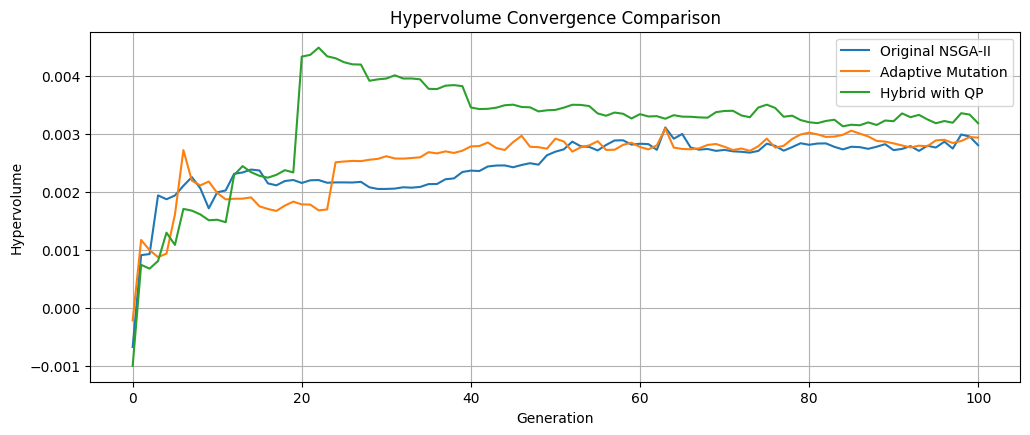

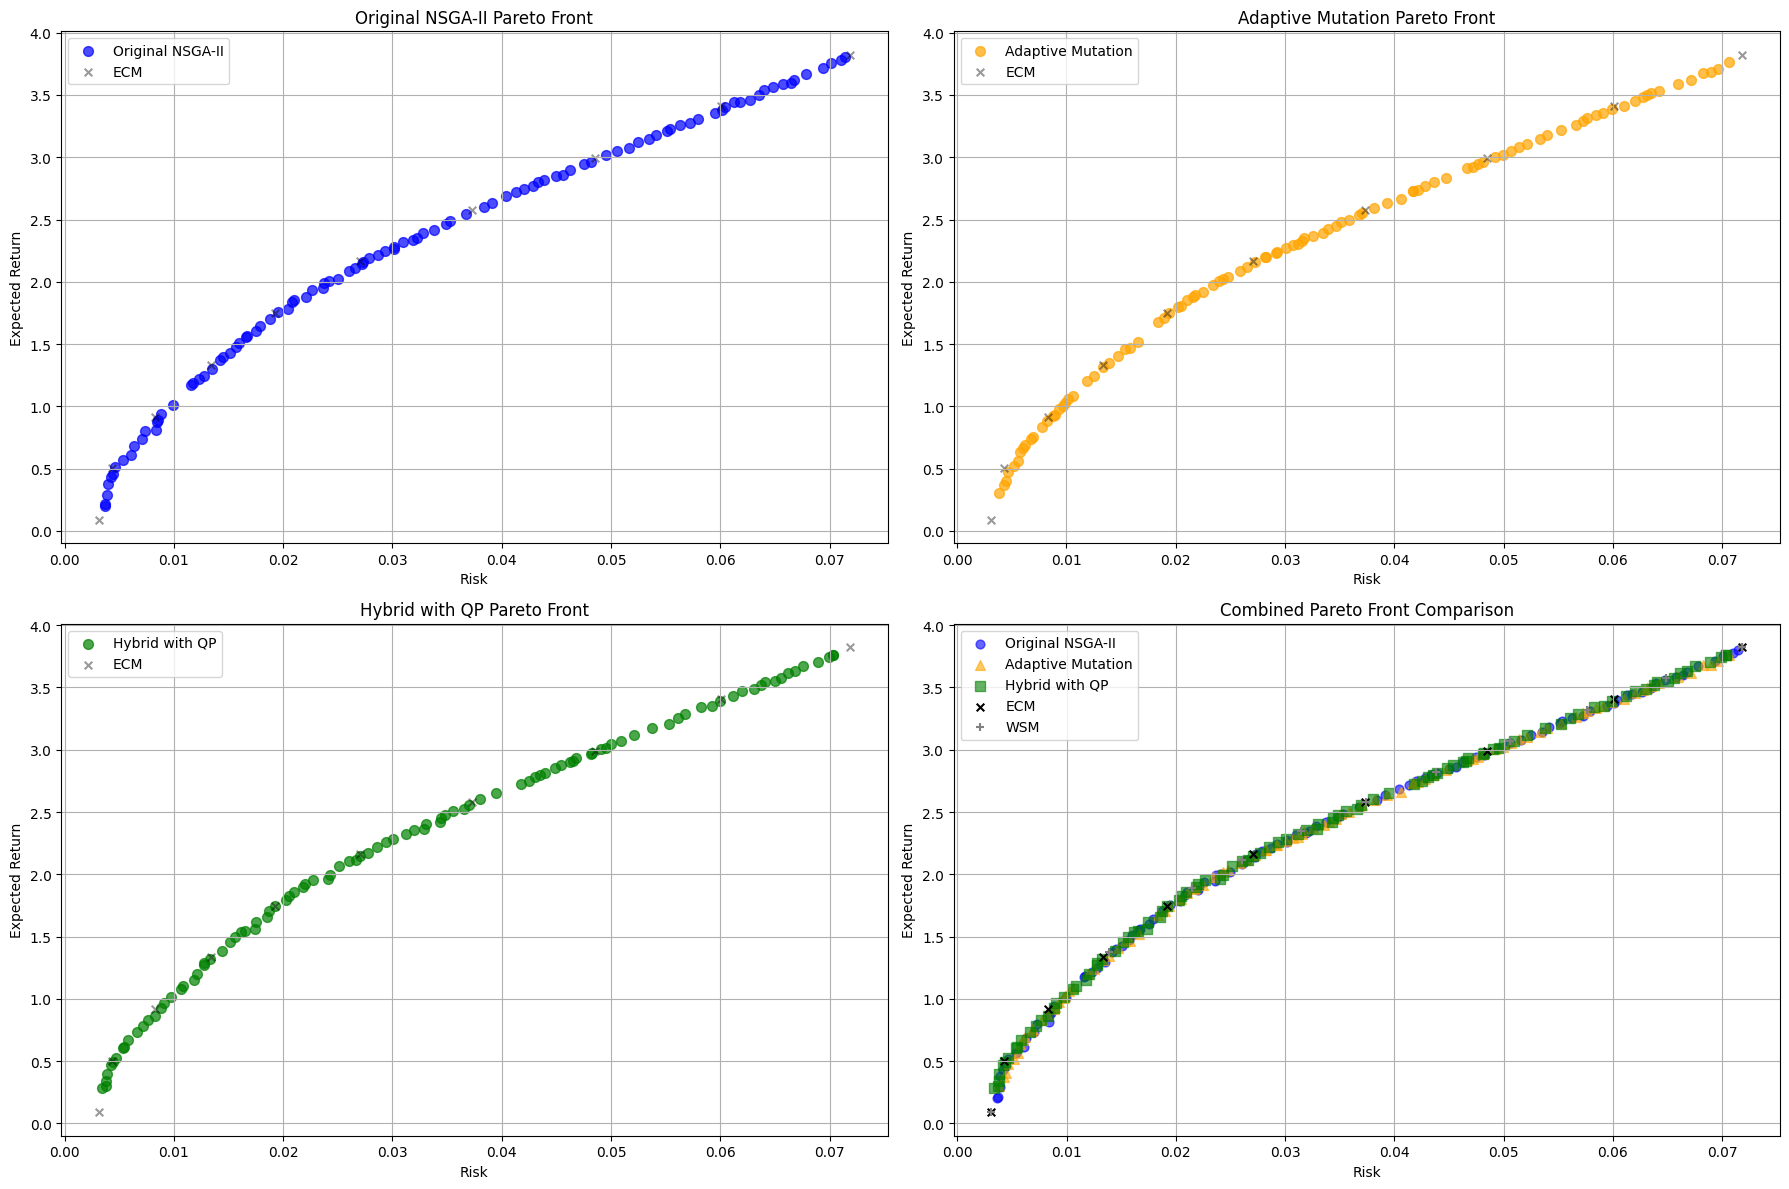

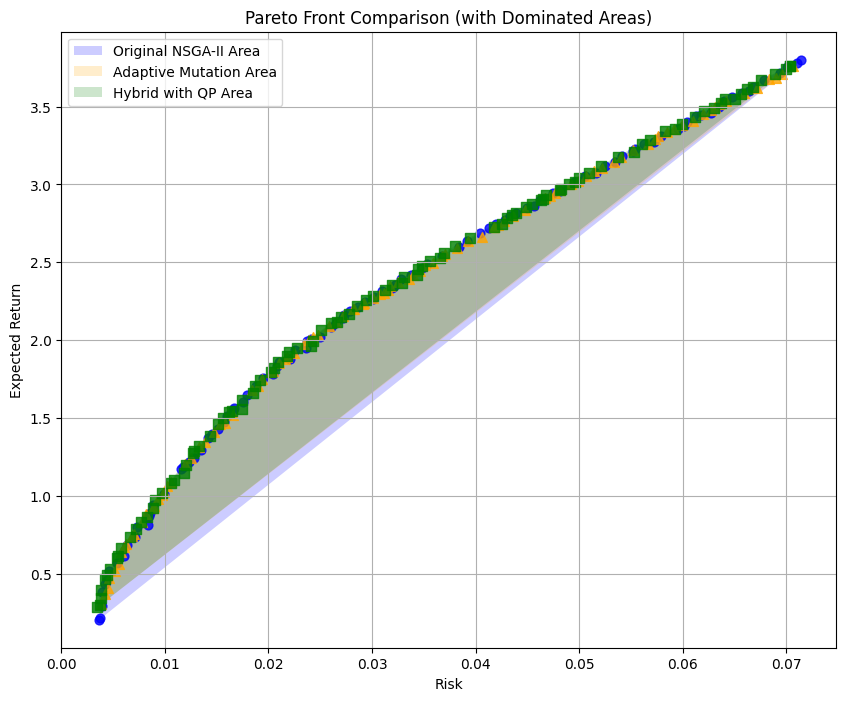

<Figure size 640x480 with 0 Axes>

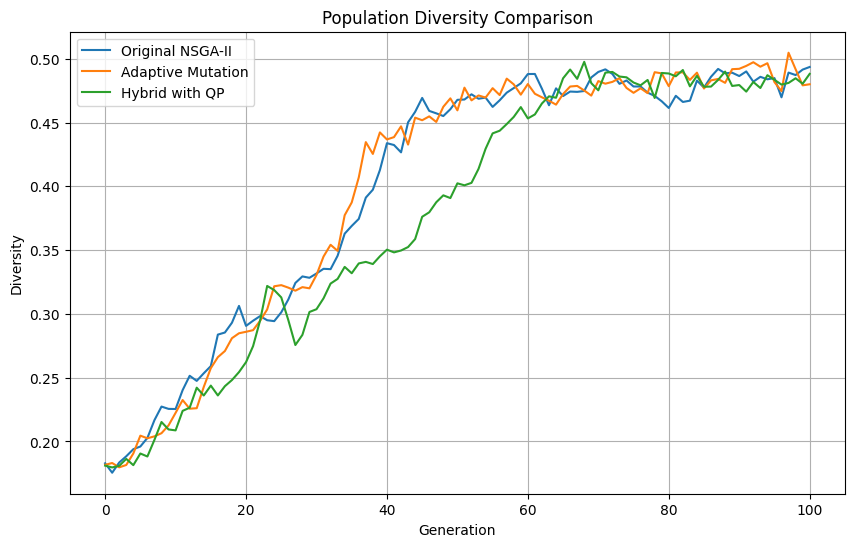


BEST PORTFOLIO COMPARISON (Maximum Sharpe Ratio)
Algorithm                      Return     Risk       Sharpe Ratio   
--------------------------------------------------------------------------------
Original NSGA-II               0.5145     0.004637   110.9496       
Adaptive Mutation              0.6918     0.006210   111.3974       
Hybrid with QP                 0.6670     0.005793   115.1340       


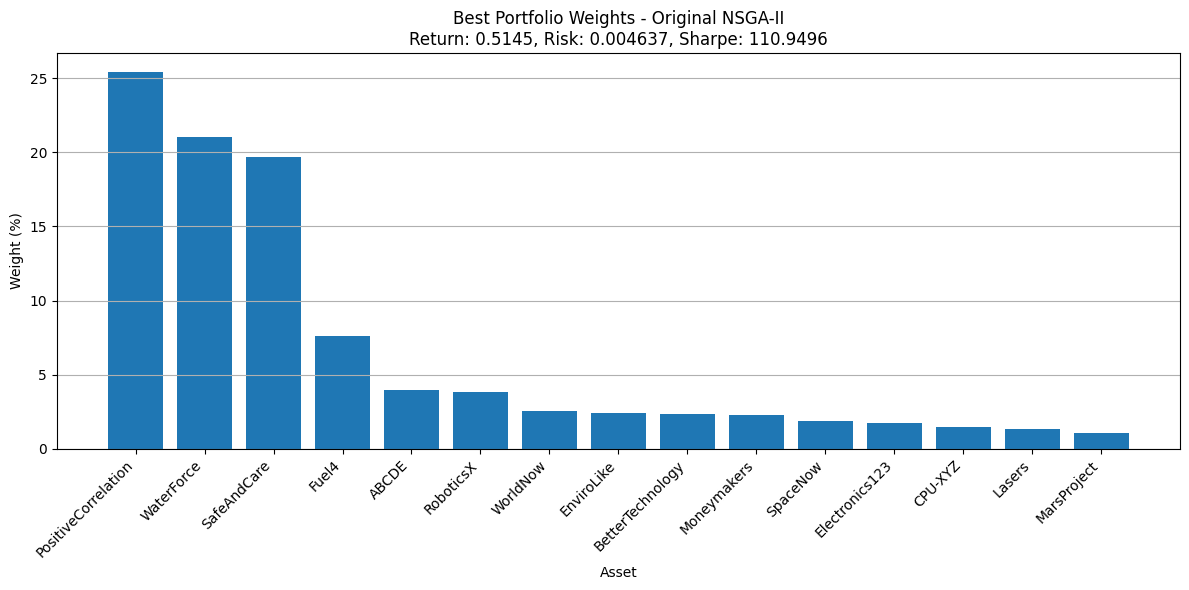

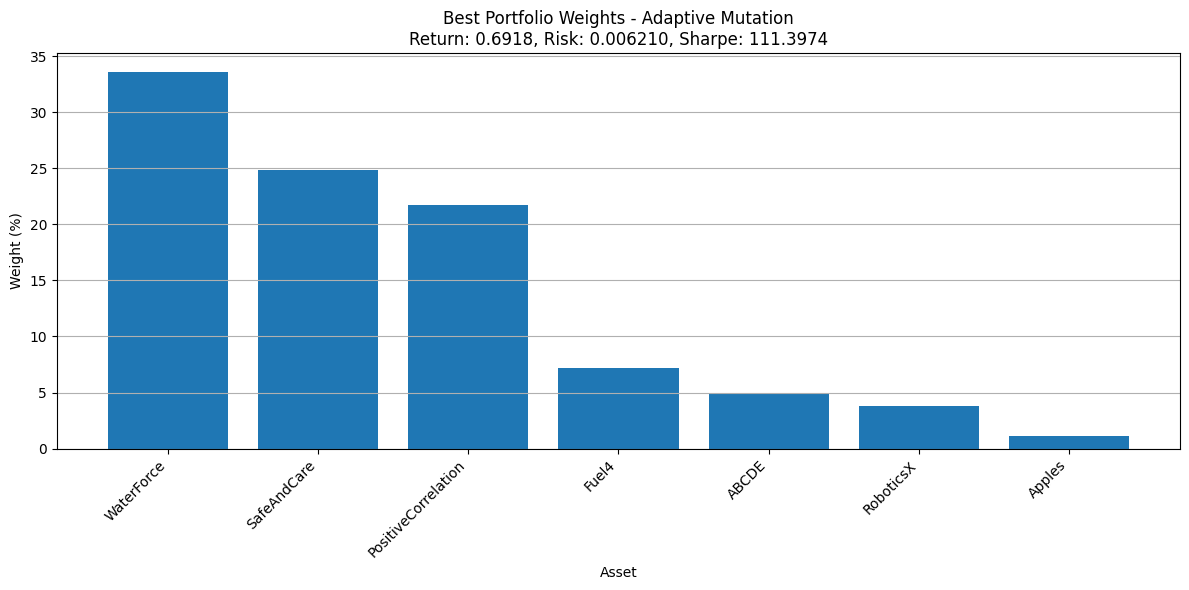

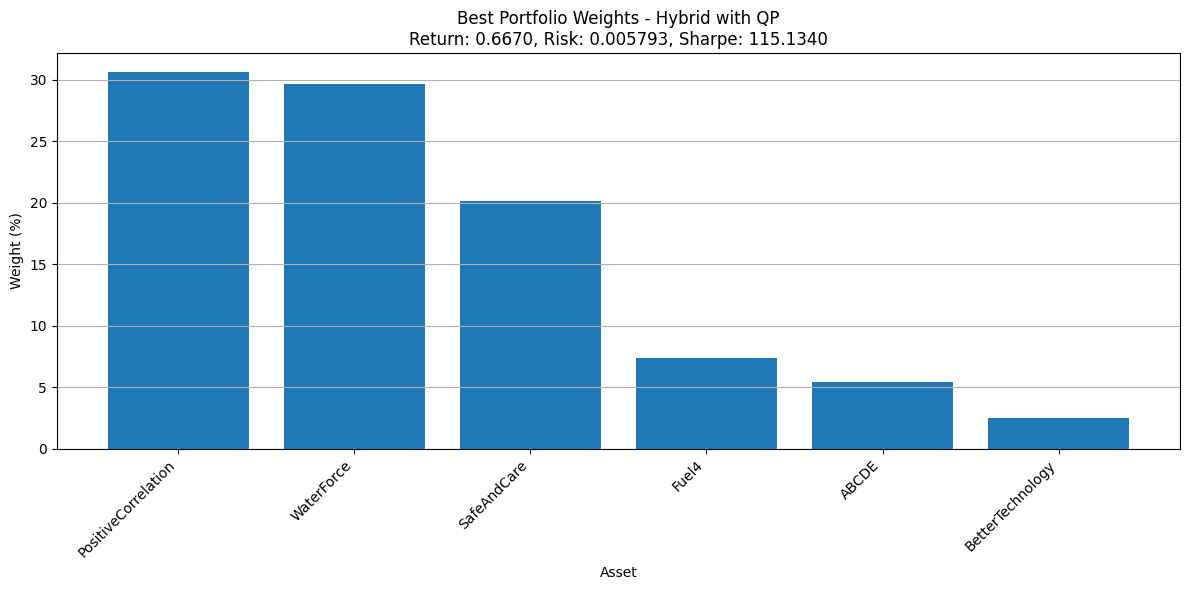

In [16]:
# Suppress solver output for cleaner console output
solvers.options['show_progress'] = False

# Make sure ecm_solutions and wsm_solutions are defined (from your previous code)
if 'ecm_solutions' not in globals() or ecm_solutions is None:
    print("No ECM solutions found. Creating empty list.")
    ecm_solutions = []

if 'wsm_solutions' not in globals() or wsm_solutions is None:
    print("No WSM solutions found. Creating empty list.")
    wsm_solutions = []

# Run comparison experiment for 2 objectives
results = run_comparison_experiment(
    n_assets=n_assets, 
    expected_returns=expected_returns, 
    cov_matrix=cov_matrix,
    asset_names=asset_names,
    ecm_solutions=ecm_solutions,
    wsm_solutions=wsm_solutions,
    n_objectives=2,
    pop_size=100,
    max_gen=100
)

Running Original NSGA-II
Set reference point: [-2.31438240e-02  1.37092411e-02 -1.65000000e+01]
Generation 10/100 completed
Generation 20/100 completed
Generation 30/100 completed
Generation 40/100 completed
Generation 50/100 completed
Generation 60/100 completed
Generation 70/100 completed
Generation 80/100 completed
Generation 90/100 completed
Generation 100/100 completed

Running NSGA-II with Adaptive Mutation
Set reference point: [-7.61613083e-03  1.38296942e-02 -1.76000000e+01]
Generation 10/100 completed
Current mutation rate: 0.0774
Generation 20/100 completed
Current mutation rate: 0.0463
Generation 30/100 completed
Current mutation rate: 0.0277
Generation 40/100 completed
Current mutation rate: 0.0166
Generation 50/100 completed
Current mutation rate: 0.0157
Generation 60/100 completed
Current mutation rate: 0.0100
Generation 70/100 completed
Current mutation rate: 0.0100
Generation 80/100 completed
Current mutation rate: 0.0100
Generation 90/100 completed
Current mutation rat

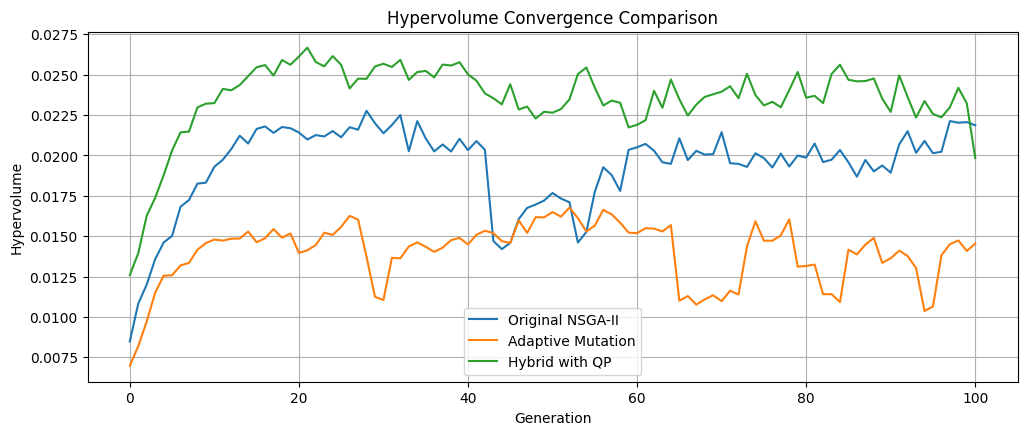

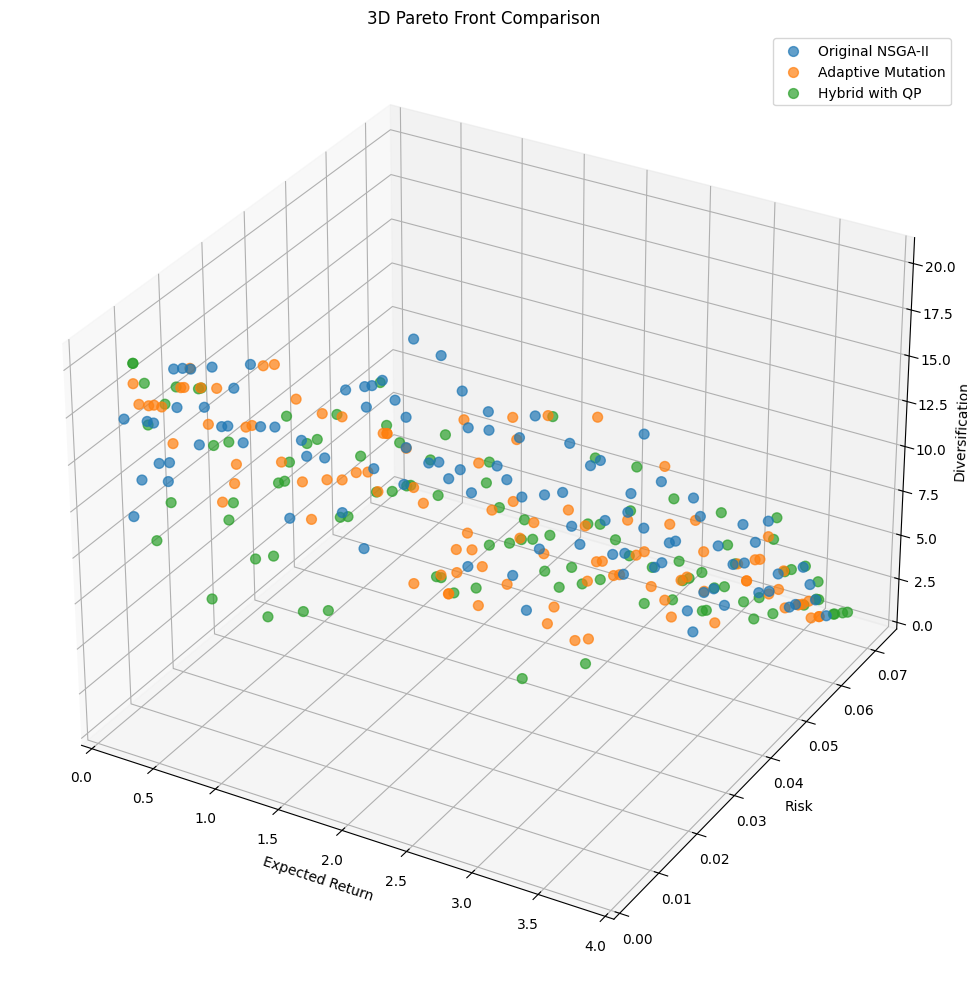

<Figure size 640x480 with 0 Axes>

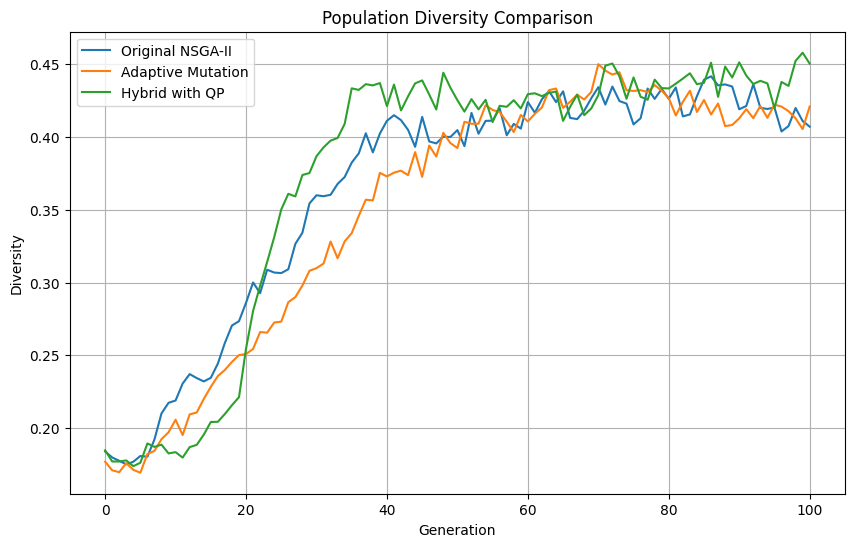


BEST PORTFOLIO COMPARISON (Maximum Sharpe Ratio)
Algorithm                      Return     Risk       Sharpe Ratio   
--------------------------------------------------------------------------------
Original NSGA-II               1.0995     0.011597   94.8160        
Adaptive Mutation              0.7875     0.008227   95.7283        
Hybrid with QP                 0.7432     0.006429   115.5981       


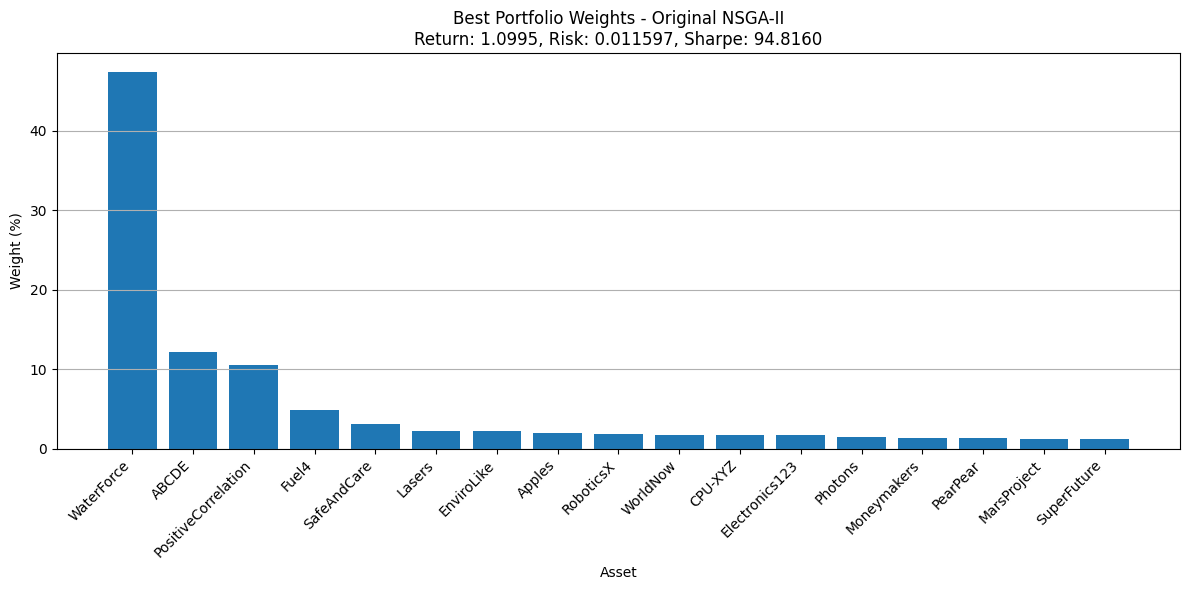

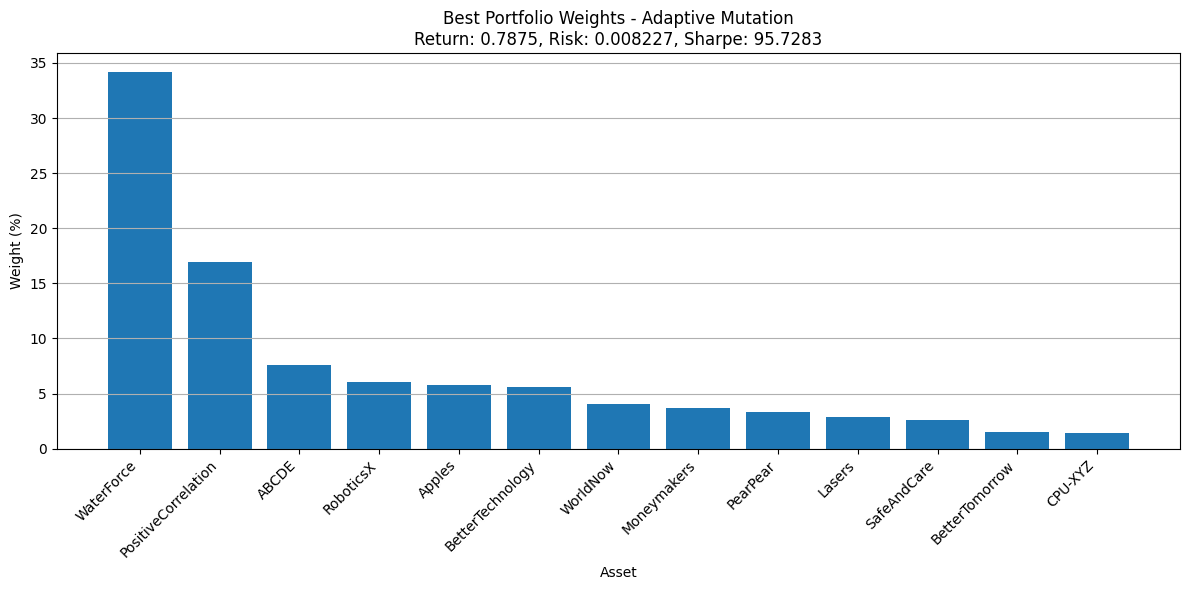

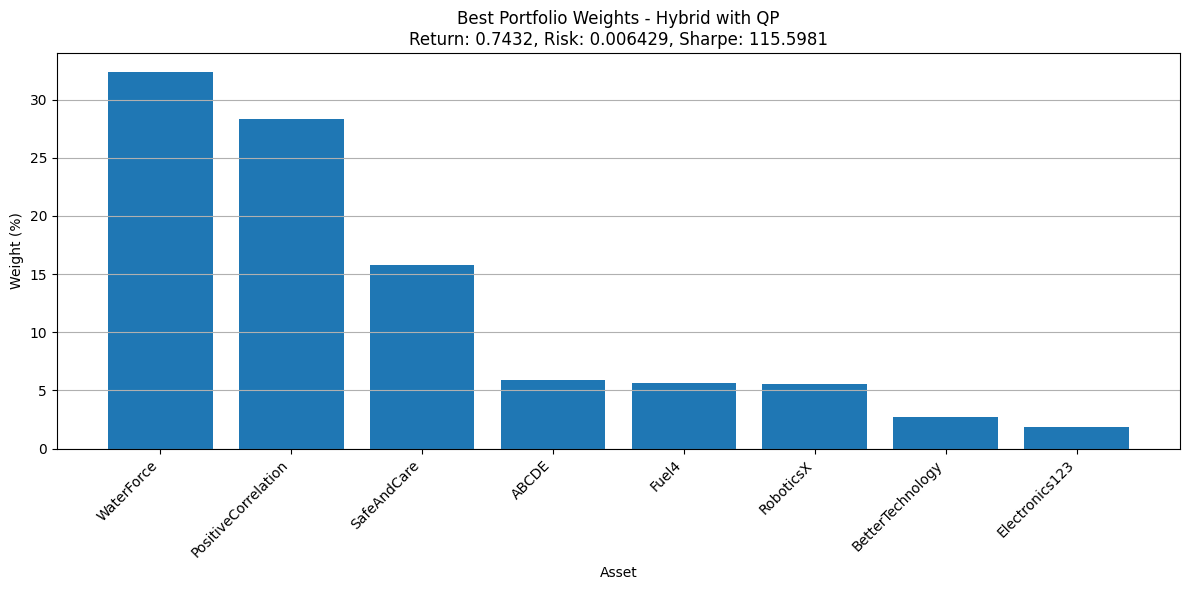

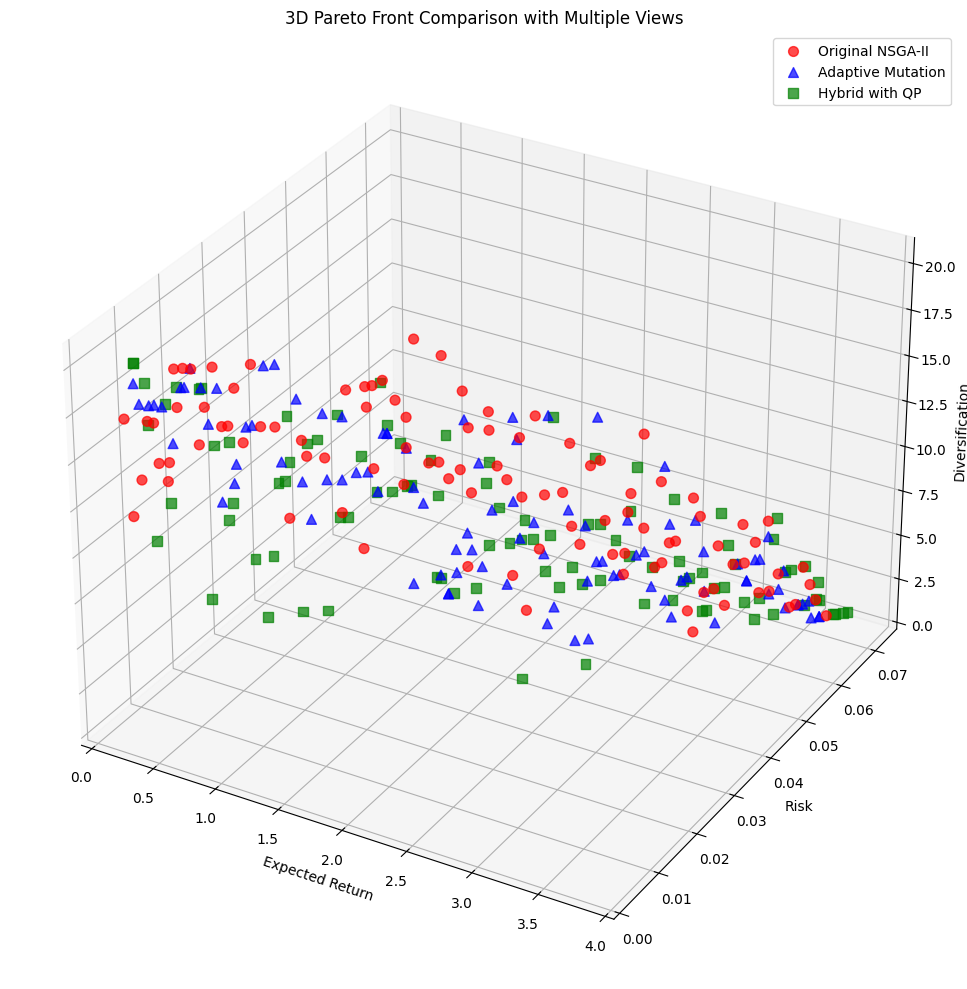

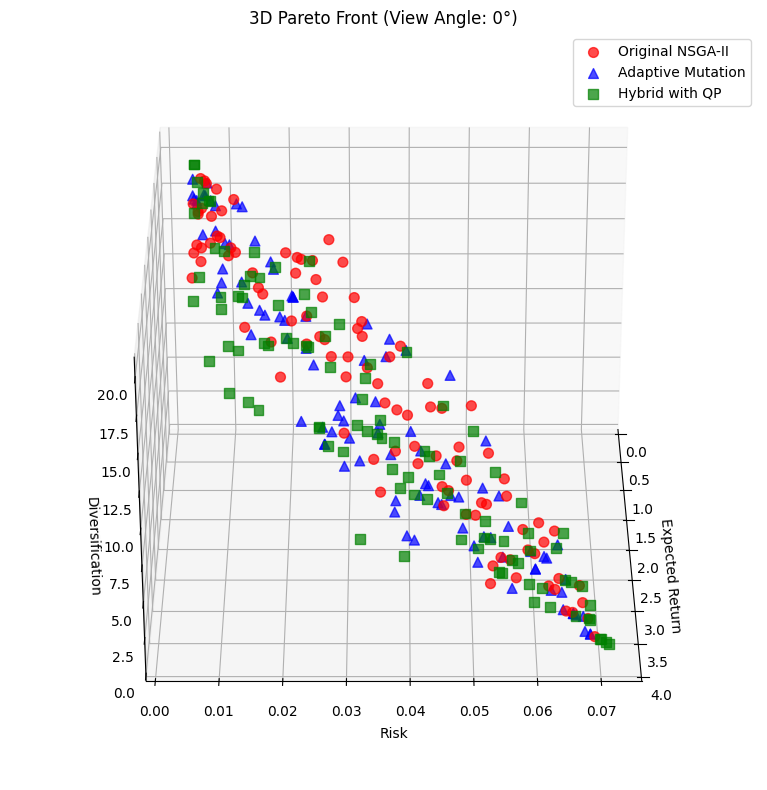

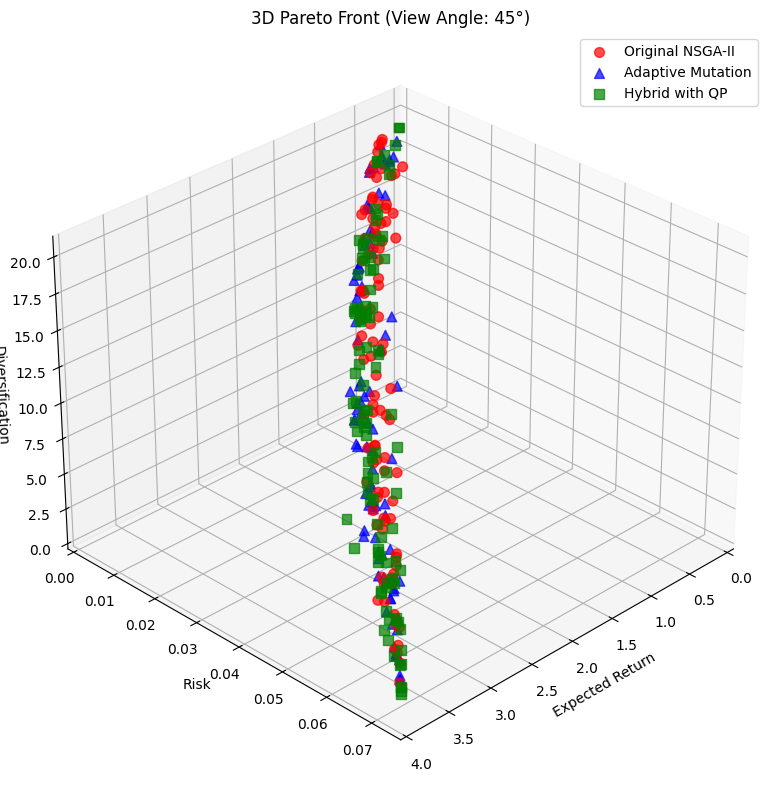

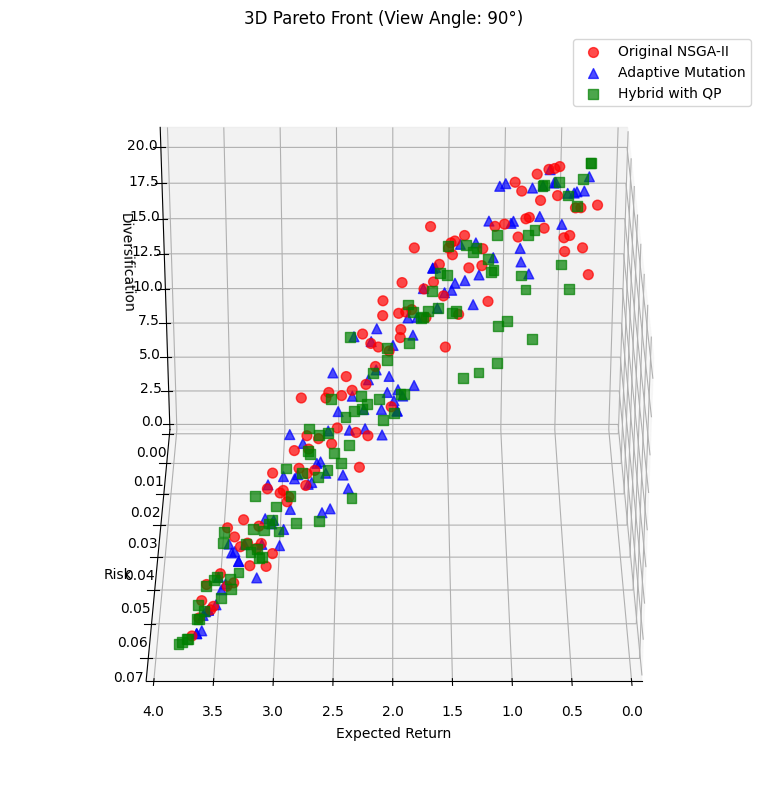

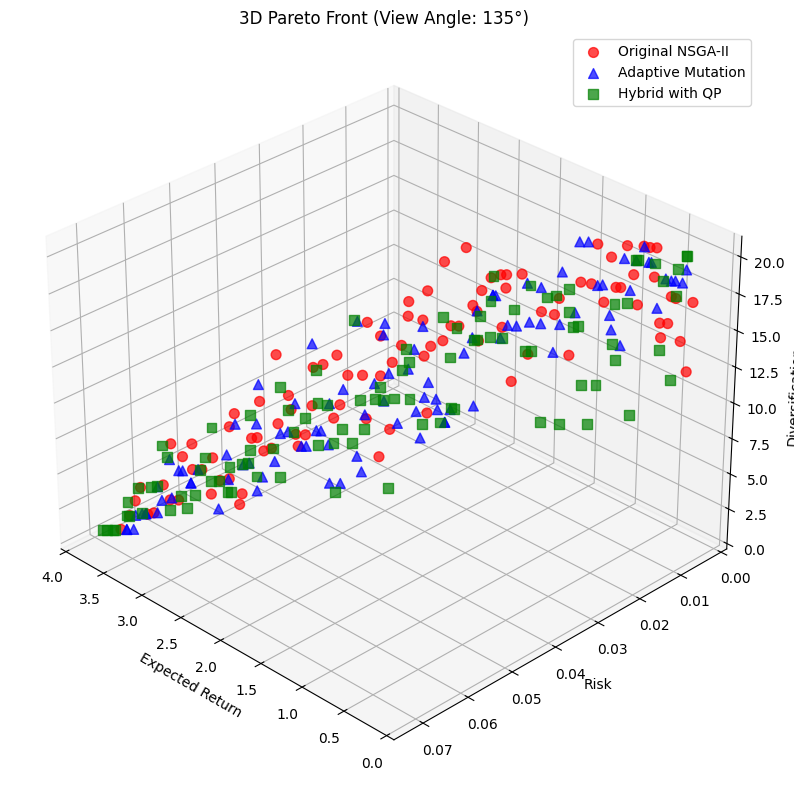

In [17]:
# Run comparison experiment for 3 objectives
results_3d = run_comparison_experiment(
    n_assets=n_assets, 
    expected_returns=expected_returns, 
    cov_matrix=cov_matrix,
    asset_names=asset_names,
    ecm_solutions=ecm_solutions,
    wsm_solutions=wsm_solutions,
    n_objectives=3,
    pop_size=100,
    max_gen=100
)

Finding the Best Portfolio Solution from QP Hybrid Results
Using pre-extracted best solution from Hybrid QP method
Return: 0.6670, Risk: 0.005793
Sharpe Ratio: 115.1340

STEP 1: Reordering weights to match the required asset order...
✓ All required assets found in the data
Sum of weights: 1.0000000000
✓ Weights sum to exactly 1.0

STEP 2: Saving solution to file...
Solution exported to 151958_151960.txt

STEP 3: Verifying file contents...
✓ File has correct format: return risk weight1 weight2 ... weight20

STEP 4: Visualizing the best portfolio...


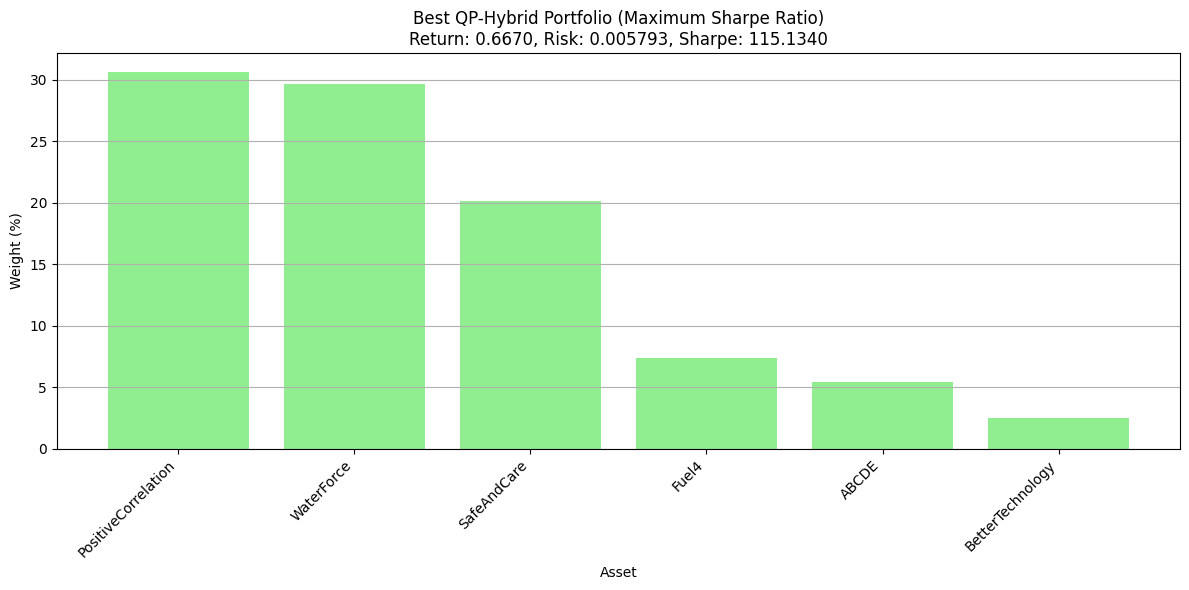


Weights in the required order (as saved in the file):
1. SuperFuture: 0.001591
2. Apples: 0.000097
3. WorldNow: 0.001549
4. Electronics123: 0.007517
5. Photons: 0.000004
6. SpaceNow: 0.005342
7. PearPear: 0.002341
8. PositiveCorrelation: 0.306167
9. BetterTechnology: 0.024592
10. ABCDE: 0.054193
11. EnviroLike: 0.001668
12. Moneymakers: 0.007921
13. Fuel4: 0.073289
14. MarsProject: 0.006288
15. CPU-XYZ: 0.002843
16. RoboticsX: 0.006323
17. Lasers: 0.000041
18. WaterForce: 0.296058
19. SafeAndCare: 0.201249
20. BetterTomorrow: 0.000927


In [18]:
# Find the best portfolio solution from QP hybrid and export to text file
print("=" * 80)
print("Finding the Best Portfolio Solution from QP Hybrid Results")
print("=" * 80)

# Define the required asset order exactly as specified in the PDF
required_order = [
    "SuperFuture", "Apples", "WorldNow", "Electronics123", "Photons",
    "SpaceNow", "PearPear", "PositiveCorrelation", "BetterTechnology", "ABCDE",
    "EnviroLike", "Moneymakers", "Fuel4", "MarsProject", "CPU-XYZ",
    "RoboticsX", "Lasers", "WaterForce", "SafeAndCare", "BetterTomorrow"
]

# Use the best solution already calculated from our experiment results
best_solutions = results['best_solutions']
if best_solutions and 'Hybrid with QP' in best_solutions:
    # Get the pre-calculated best solution
    best_solution_data = best_solutions['Hybrid with QP']
    best_solution = best_solution_data['solution']
    expected_return = best_solution_data['return']
    expected_risk = best_solution_data['risk']
    sharpe_ratio = best_solution_data['sharpe']
    
    print(f"Using pre-extracted best solution from Hybrid QP method")
    print(f"Return: {expected_return:.4f}, Risk: {expected_risk:.6f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    
    # STEP 1: First reorder the weights to match the required order
    print("\nSTEP 1: Reordering weights to match the required asset order...")
    
    # Create mapping from asset names to weights
    weights_dict = {name: weight for name, weight in zip(asset_names, best_solution['weights'])}
    
    # Verify all required assets exist in our data
    missing_assets = [asset for asset in required_order if asset not in weights_dict]
    if missing_assets:
        print(f"ERROR: Missing assets in our data: {missing_assets}")
    else:
        print("✓ All required assets found in the data")
    
    # Reorder weights according to required order
    ordered_weights = [weights_dict[asset] for asset in required_order]
    
    # Verify the weights sum to 1.0
    total_weight = np.sum(ordered_weights)
    print(f"Sum of weights: {total_weight:.10f}")
    assert abs(total_weight - 1.0) < 1e-10, "Weights must sum to exactly 1.0"
    print("✓ Weights sum to exactly 1.0")
    
    # STEP 2: Save to file in the format specified in the PDF
    print("\nSTEP 2: Saving solution to file...")
    filename = "151958_151960.txt"
    
    # Create the line to write to the file (using dots for decimal points as specified)
    line = f"{expected_return:.4f} {expected_risk:.4f}"
    for weight in ordered_weights:
        line += f" {weight:.6f}"
    
    # Write to the file
    with open(filename, 'w') as f:
        f.write(line)
    print(f"Solution exported to {filename}")
    
    # STEP 3: Verify the file was saved correctly
    print("\nSTEP 3: Verifying file contents...")
    with open(filename, 'r') as f:
        saved_content = f.read().strip()
    
    # Verify the number of elements in the saved line
    elements = saved_content.split()
    assert len(elements) == 22, f"Expected 22 elements (2 + 20 weights), found {len(elements)}"
    print("✓ File has correct format: return risk weight1 weight2 ... weight20")
    
    # STEP 4: Visualize the best portfolio weights
    print("\nSTEP 4: Visualizing the best portfolio...")
    significant_weights = [(asset, weight) for asset, weight in zip(required_order, ordered_weights) if weight > 0.01]
    significant_weights.sort(key=lambda x: x[1], reverse=True)
    
    # Plot as a bar chart
    plt.figure(figsize=(12, 6))
    assets = [item[0] for item in significant_weights]
    weights = [item[1] * 100 for item in significant_weights]
    
    bars = plt.bar(assets, weights, color='lightgreen')
    plt.xlabel('Asset')
    plt.ylabel('Weight (%)')
    plt.title(f"Best QP-Hybrid Portfolio (Maximum Sharpe Ratio)\nReturn: {expected_return:.4f}, Risk: {expected_risk:.6f}, Sharpe: {sharpe_ratio:.4f}")
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()
    
    # Print the weights in the specified order
    print("\nWeights in the required order (as saved in the file):")
    for i, asset_name in enumerate(required_order):
        print(f"{i+1}. {asset_name}: {ordered_weights[i]:.6f}")
else:
    print("QP hybrid results not found. Please run the experiment first.")